# Section 1: Setup & Environment


## Cell 1.2: Import Libraries


In [ ]:
# Standard libraries
import os
import random
import numpy as np
import zipfile
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# Misc
from tqdm import tqdm
import time

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


## Cell 1.3: Set Random Seeds


In [ ]:
# Set random seeds for reproducibility
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✅ Random seeds set to 42")

✅ Random seeds set to 42


## Cell 1.4: Mount Google Drive


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully!")

# Define paths
BASE_PATH = '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1'
DATA_ZIP_PATH = os.path.join(BASE_PATH, 'data/faceforensics_dataset.zip')
MODEL_DIR = os.path.join(BASE_PATH, 'models')

# Verify paths exist
if os.path.exists(DATA_ZIP_PATH):
    print(f"✅ Found dataset: {os.path.basename(DATA_ZIP_PATH)}")
else:
    print(f"❌ Dataset not found at: {DATA_ZIP_PATH}")

if os.path.exists(MODEL_DIR):
    print(f"✅ Found model directory")
else:
    print(f"❌ Model directory not found at: {MODEL_DIR}")

Mounted at /content/drive
✅ Google Drive mounted successfully!
✅ Found dataset: faceforensics_dataset.zip
✅ Found model directory


## Cell 1.5: Set Device


In [ ]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🖥️ Device Configuration:")
print(f"   Device: {device}")

if device.type == 'cuda':
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    print(f"   ✅ Using GPU for evaluation!")
else:
    print(f"   ⚠️ GPU not available, using CPU")

🖥️ Device Configuration:
   Device: cpu
   ⚠️ GPU not available, using CPU


---

# Section 2: Load Data


## Cell 2.1: Extract Dataset


In [ ]:
# Define extraction directory
EXTRACT_DIR = '/content/extracted_data'

# Create directory if it doesn't exist
os.makedirs(EXTRACT_DIR, exist_ok=True)

print(f"📂 Extracting to: {EXTRACT_DIR}")
print(f"⏳ This may take a moment...")

start_time = time.time()

# Extract zip file
with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

elapsed = time.time() - start_time

print(f"✅ Extraction complete in {elapsed:.2f} seconds")

# List extracted files
print(f"\n📄 Extracted files:")
extracted_files = os.listdir(EXTRACT_DIR)
for file in extracted_files:
    file_path = os.path.join(EXTRACT_DIR, file)
    if os.path.isfile(file_path):
        size_mb = os.path.getsize(file_path) / (1024**2)
        print(f"   • {file} ({size_mb:.2f} MB)")

📂 Extracting to: /content/extracted_data
⏳ This may take a moment...
✅ Extraction complete in 64.40 seconds

📄 Extracted files:
   • FaceForensics_stats.pt (0.00 MB)
   • FaceForensics_X.pt (4668.75 MB)
   • FaceForensics_y.pt (0.76 MB)


## Cell 2.2: Load Tensors


In [ ]:
# Define paths to extracted tensor files
X_path = os.path.join(EXTRACT_DIR, 'FaceForensics_X.pt')
y_path = os.path.join(EXTRACT_DIR, 'FaceForensics_y.pt')

# Load tensors
print(f"📂 Loading X tensor from: {os.path.basename(X_path)}")
X = torch.load(X_path)

print(f"📂 Loading y tensor from: {os.path.basename(y_path)}")
y = torch.load(y_path)

print(f"\n✅ Tensors loaded successfully!")

# Display tensor information
print(f"\n📊 Tensor Information:")
print(f"   X shape: {X.shape} (N, C, H, W)")
print(f"   y shape: {y.shape} (N,)")
print(f"   X dtype: {X.dtype}")
print(f"   y dtype: {y.dtype}")
print(f"   X range: [{X.min():.4f}, {X.max():.4f}]")
print(f"   y unique values: {torch.unique(y).tolist()}")

# Memory usage
X_memory = X.element_size() * X.nelement() / (1024**3)
y_memory = y.element_size() * y.nelement() / (1024**2)

print(f"\n💾 Memory Usage:")
print(f"   X tensor: {X_memory:.2f} GB")
print(f"   y tensor: {y_memory:.2f} MB")

📂 Loading X tensor from: FaceForensics_X.pt
📂 Loading y tensor from: FaceForensics_y.pt

✅ Tensors loaded successfully!

📊 Tensor Information:
   X shape: torch.Size([99600, 3, 64, 64]) (N, C, H, W)
   y shape: torch.Size([99600]) (N,)
   X dtype: torch.float32
   y dtype: torch.int64
   X range: [0.0000, 1.0000]
   y unique values: [0, 1]

💾 Memory Usage:
   X tensor: 4.56 GB
   y tensor: 0.76 MB


## Cell 2.3: Shuffle and Split Data


In [ ]:
# Get total number of samples
num_samples = X.shape[0]

# Create indices for all samples
indices = torch.randperm(num_samples)

# Shuffle X and y using the same indices
X_shuffled = X[indices]
y_shuffled = y[indices]

print(f"✅ Data shuffled with random seed {RANDOM_SEED}")

# Use 90/10 split
train_ratio = 0.9
test_ratio = 0.1

# Calculate split sizes
train_size = int(num_samples * train_ratio)
test_size = num_samples - train_size

print(f"\n✂️ TRAIN/TEST SPLIT")
print(f"   Total samples: {num_samples:,}")
print(f"   Train size: {train_size:,} ({train_ratio*100:.0f}%)")
print(f"   Test size: {test_size:,} ({test_ratio*100:.0f}%)")

# Split data
X_train = X_shuffled[:train_size]
y_train = y_shuffled[:train_size]

X_test = X_shuffled[train_size:]
y_test = y_shuffled[train_size:]

print(f"\n✅ Split complete!")
print(f"   Train samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

# Clean up
del X, y, X_shuffled, y_shuffled, indices
import gc
gc.collect()

print(f"\n✅ Original tensors cleared from memory")

✅ Data shuffled with random seed 42

✂️ TRAIN/TEST SPLIT
   Total samples: 99,600
   Train size: 89,640 (90%)
   Test size: 9,960 (10%)

✅ Split complete!
   Train samples: 89,640
   Test samples: 9,960

✅ Original tensors cleared from memory


## Cell 2.4: Create DataLoader

In [ ]:
# Configuration
BATCH_SIZE = 64
NUM_WORKERS = 2

# Create test dataset
test_dataset = TensorDataset(X_test, y_test)

# Create test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"📦 Test DataLoader created:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Test batches: {len(test_loader):,}")
print(f"   Test samples: {len(test_dataset):,}")
print(f"\n✅ DataLoader ready!")

📦 Test DataLoader created:
   Batch size: 64
   Test batches: 156
   Test samples: 9,960

✅ DataLoader ready!


---

# Section 3: Load Model

## Cell 3.1: Define Model Architecture


In [ ]:
class SimpleCNN(nn.Module):
    """
    Simple CNN for binary classification (Real vs Fake)
    Architecture: Conv layers → Flatten → FC layers → Output
    """

    def __init__(self, input_channels=3, num_classes=2):
        """
        Initialize the CNN model

        Args:
            input_channels (int): Number of input channels (3 for RGB)
            num_classes (int): Number of output classes (2 for binary)
        """
        super(SimpleCNN, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input images (batch, 3, 64, 64)

        Returns:
            torch.Tensor: Class logits (batch, 2)
        """
        # Conv block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

print("✅ Model architecture defined")

✅ Model architecture defined


## Cell 3.2: Load Trained Model

In [ ]:
# Initialize model
model = SimpleCNN(input_channels=3, num_classes=2)
model = model.to(device)

print(f"🔧 Model initialized")

# Load the final trained model
final_model_path = os.path.join(MODEL_DIR, 'final_model.pt')

if os.path.exists(final_model_path):
    print(f"\n📥 Loading model from: {os.path.basename(final_model_path)}")

    checkpoint = torch.load(final_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✅ Model loaded successfully!")

    # Display training history from checkpoint
    if 'train_accuracy' in checkpoint:
        print(f"\n📊 Training History:")
        print(f"   Epochs trained: {checkpoint.get('num_epochs', 'Unknown')}")
        print(f"   Final training accuracy: {checkpoint['train_accuracy'][-1]:.2f}%")
        print(f"   Final training loss: {checkpoint['train_loss'][-1]:.4f}")

        # Store history for later comparison
        train_accuracy_final = checkpoint['train_accuracy'][-1]
        train_loss_final = checkpoint['train_loss'][-1]
else:
    print(f"❌ Model file not found at: {final_model_path}")
    print(f"   Please check the path!")
    raise FileNotFoundError("Model file not found!")

# Set model to evaluation mode
model.eval()
print(f"\n✅ Model set to evaluation mode")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Model size: {total_params * 4 / (1024**2):.2f} MB")

🔧 Model initialized

📥 Loading model from: final_model.pt
✅ Model loaded successfully!

📊 Training History:
   Epochs trained: 10
   Final training accuracy: 97.52%
   Final training loss: 0.0599

✅ Model set to evaluation mode

📊 Model Statistics:
   Total parameters: 1,054,050
   Model size: 4.02 MB


---

# Section 4: Run Evaluation

## Cell 4.1: Evaluate on Test Set

In [ ]:
print("\n" + "="*60)
print("🎯 RUNNING EVALUATION ON TEST SET")
print("="*60)

# Storage for predictions and labels
all_predictions = []
all_labels = []
all_probs = []

print(f"\n📊 Test set: {len(test_loader.dataset):,} samples")
print(f"   Processing {len(test_loader)} batches...")

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        # Move to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get probabilities (apply softmax to logits)
        probs = F.softmax(outputs, dim=1)

        # Get predicted class (0 or 1)
        _, predicted = torch.max(outputs, 1)

        # Store results
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"\n✅ Evaluation complete!")
print(f"   Predictions collected: {len(all_predictions):,}")


🎯 RUNNING EVALUATION ON TEST SET

📊 Test set: 9,960 samples
   Processing 156 batches...


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 156/156 [00:13<00:00, 11.63it/s]


✅ Evaluation complete!
   Predictions collected: 9,960


## Cell 4.2: Calculate Metrics


In [ ]:
# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Precision (of predicted fakes, how many are actually fake?)
precision = precision_score(all_labels, all_predictions)

# Recall (of actual fakes, how many did we catch?)
recall = recall_score(all_labels, all_predictions)

# F1 Score (harmonic mean of precision and recall)
f1 = f1_score(all_labels, all_predictions)

# ROC AUC (area under ROC curve)
roc_auc = roc_auc_score(all_labels, all_probs[:, 1])

print(f"\n{'='*60}")
print(f"🎯 TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"\n📈 Overall Metrics:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

# Per-class accuracy
real_mask = all_labels == 0
fake_mask = all_labels == 1

real_correct = (all_predictions[real_mask] == 0).sum()
fake_correct = (all_predictions[fake_mask] == 1).sum()

real_total = real_mask.sum()
fake_total = fake_mask.sum()

real_accuracy = (real_correct / real_total) * 100
fake_accuracy = (fake_correct / fake_total) * 100

print(f"\n📊 Per-Class Performance:")
print(f"   Real (Class 0):")
print(f"      Accuracy: {real_accuracy:.2f}%")
print(f"      Correct: {real_correct}/{real_total}")
print(f"\n   Fake (Class 1):")
print(f"      Accuracy: {fake_accuracy:.2f}%")
print(f"      Correct: {fake_correct}/{fake_total}")

# Training vs Test comparison
if 'train_accuracy_final' in locals():
    gap = train_accuracy_final - (accuracy * 100)

    print(f"\n📉 Train vs Test:")
    print(f"   Training Accuracy: {train_accuracy_final:.2f}%")
    print(f"   Test Accuracy:     {accuracy*100:.2f}%")
    print(f"   Gap:               {gap:.2f}%")

    if gap < 2:
        print(f"   ✅ Excellent generalization!")
    elif gap < 5:
        print(f"   ✅ Good generalization")
    elif gap < 10:
        print(f"   ⚠️ Slight overfitting")
    else:
        print(f"   ⚠️ Significant overfitting detected")


🎯 TEST SET PERFORMANCE

📈 Overall Metrics:
   Accuracy:  97.42%
   Precision: 0.9731
   Recall:    0.9749
   F1-Score:  0.9740
   ROC-AUC:   0.9977

📊 Per-Class Performance:
   Real (Class 0):
      Accuracy: 97.35%
      Correct: 4892/5025

   Fake (Class 1):
      Accuracy: 97.49%
      Correct: 4811/4935

📉 Train vs Test:
   Training Accuracy: 97.52%
   Test Accuracy:     97.42%
   Gap:               0.10%
   ✅ Excellent generalization!


---

# Section 5: Visualizations


## Cell 5.1: Confusion Matrix


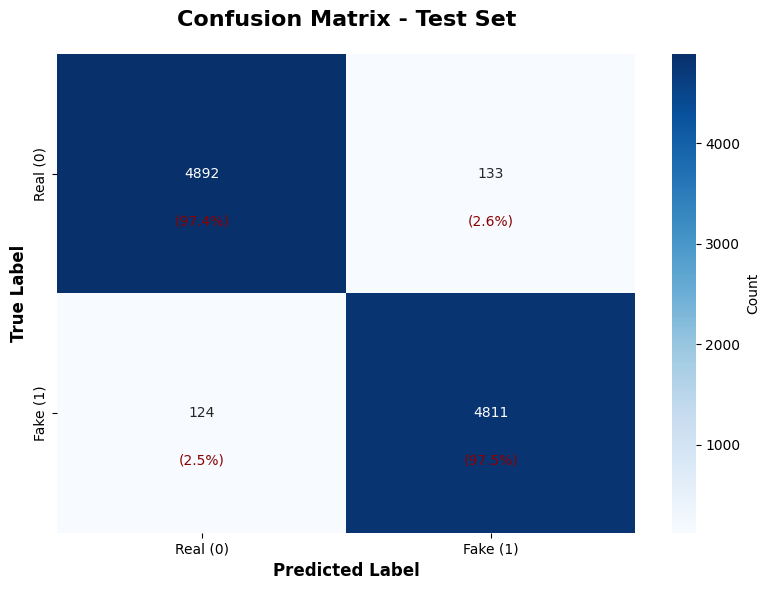


📊 Confusion Matrix Breakdown:

   True Negatives  (Real predicted as Real): 4,892
   False Positives (Real predicted as Fake): 133
   False Negatives (Fake predicted as Real): 124
   True Positives  (Fake predicted as Fake): 4,811

⚠️ Error Analysis:
   False Positive Rate: 2.65%
      (Real videos wrongly flagged as fake)
   False Negative Rate: 2.51%
      (Fake videos missed - most dangerous!)


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create figure
plt.figure(figsize=(8, 6))

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        total = cm[i].sum()
        percentage = (count / total) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='darkred')

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"\n   True Negatives  (Real predicted as Real): {cm[0, 0]:,}")
print(f"   False Positives (Real predicted as Fake): {cm[0, 1]:,}")
print(f"   False Negatives (Fake predicted as Real): {cm[1, 0]:,}")
print(f"   True Positives  (Fake predicted as Fake): {cm[1, 1]:,}")

# Calculate error rates
false_positive_rate = cm[0, 1] / cm[0].sum() * 100
false_negative_rate = cm[1, 0] / cm[1].sum() * 100

print(f"\n⚠️ Error Analysis:")
print(f"   False Positive Rate: {false_positive_rate:.2f}%")
print(f"      (Real videos wrongly flagged as fake)")
print(f"   False Negative Rate: {false_negative_rate:.2f}%")
print(f"      (Fake videos missed - most dangerous!)")

## Cell 5.2: ROC Curve


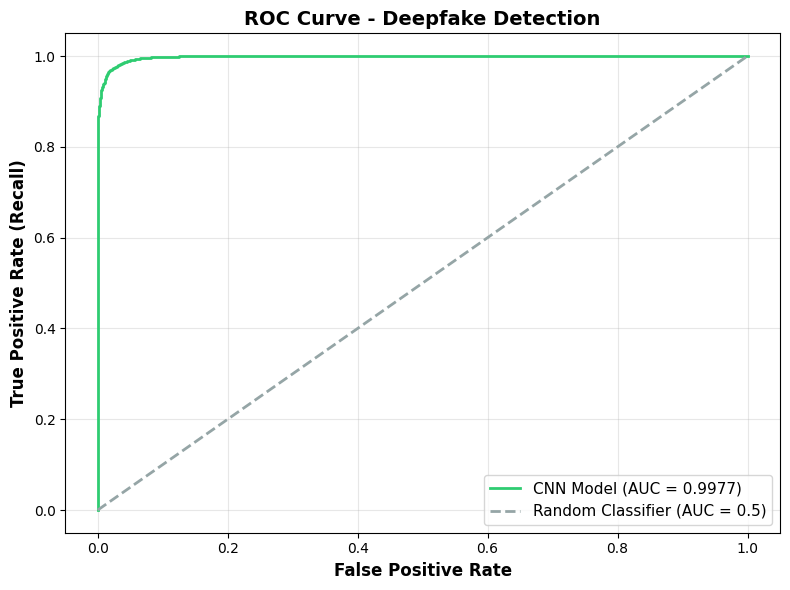

✅ ROC curve displayed

💡 Interpretation:
   AUC = 0.9977
   ✅ Excellent discrimination ability!


In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])

# Calculate AUC
auc_score = roc_auc_score(all_labels, all_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'CNN Model (AUC = {auc_score:.4f})', color='#2ecc71')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2, label='Random Classifier (AUC = 0.5)', color='#95a5a6')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Deepfake Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ ROC curve displayed")
print(f"\n💡 Interpretation:")
print(f"   AUC = {auc_score:.4f}")
if auc_score > 0.95:
    print(f"   ✅ Excellent discrimination ability!")
elif auc_score > 0.90:
    print(f"   ✅ Very good discrimination")
elif auc_score > 0.80:
    print(f"   ✅ Good discrimination")
else:
    print(f"   ⚠️ Fair discrimination, room for improvement")

---

# Section 6: Sample Predictions


## Cell 6.1: Correctly Classified Samples



✅ SAMPLE CORRECT PREDICTIONS


/tmp/ipython-input-2712185055.py:42: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


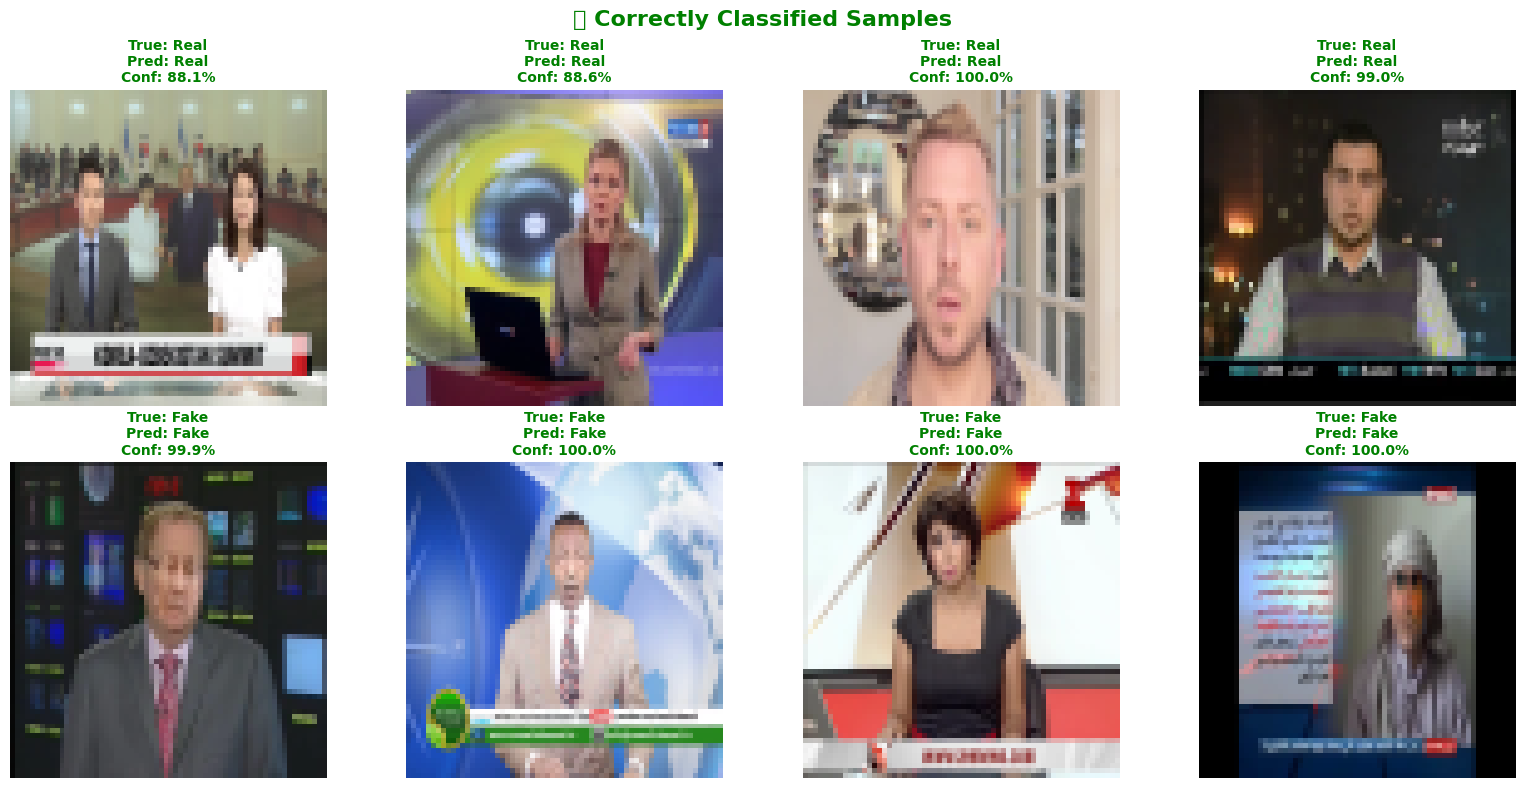

✅ Displayed 8 correctly classified samples
   Top row: Real videos correctly identified
   Bottom row: Fake videos correctly identified


In [ ]:
print("\n✅ SAMPLE CORRECT PREDICTIONS")
print("="*60)

# Find correctly classified samples
correct_mask = (all_predictions == all_labels)

# Sample correct predictions (4 real, 4 fake)
correct_real_indices = np.where((all_predictions == 0) & (all_labels == 0))[0]
correct_fake_indices = np.where((all_predictions == 1) & (all_labels == 1))[0]

# Randomly select 4 from each
np.random.seed(RANDOM_SEED)
sample_real_correct = np.random.choice(correct_real_indices, min(4, len(correct_real_indices)), replace=False)
sample_fake_correct = np.random.choice(correct_fake_indices, min(4, len(correct_fake_indices)), replace=False)

# Create visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('✅ Correctly Classified Samples', fontsize=16, fontweight='bold', color='green')

# Plot correctly classified real images
for idx, test_idx in enumerate(sample_real_correct):
    img_tensor = X_test[test_idx]
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    confidence = all_probs[test_idx, 0] * 100

    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'True: Real\nPred: Real\nConf: {confidence:.1f}%',
                          fontsize=10, color='green', fontweight='bold')
    axes[0, idx].axis('off')

# Plot correctly classified fake images
for idx, test_idx in enumerate(sample_fake_correct):
    img_tensor = X_test[test_idx]
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    confidence = all_probs[test_idx, 1] * 100

    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'True: Fake\nPred: Fake\nConf: {confidence:.1f}%',
                          fontsize=10, color='green', fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Displayed 8 correctly classified samples")
print(f"   Top row: Real videos correctly identified")
print(f"   Bottom row: Fake videos correctly identified")

## Cell 6.2: Misclassified Samples



❌ SAMPLE MISCLASSIFICATIONS
📊 Misclassification Analysis:
   Total misclassified: 257
   Misclassification rate: 2.58%

   False Positives (Real→Fake): 133
   False Negatives (Fake→Real): 124


/tmp/ipython-input-707036202.py:58: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


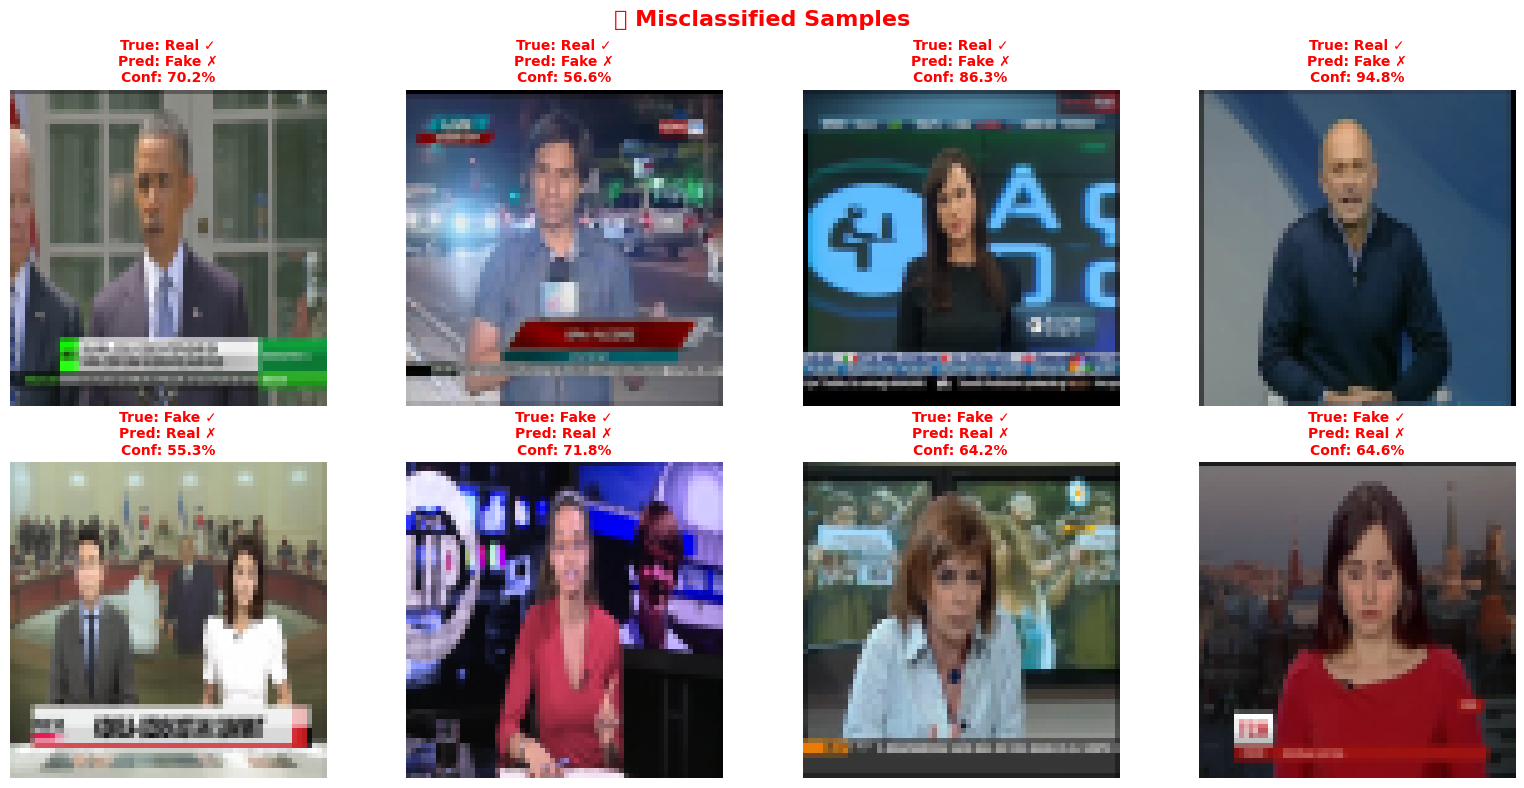


✅ Displayed misclassified samples
   Top row: Real videos wrongly flagged as Fake
   Bottom row: Fake videos that fooled the model


In [ ]:
print("\n❌ SAMPLE MISCLASSIFICATIONS")
print("="*60)

# Find misclassified samples
incorrect_mask = (all_predictions != all_labels)
incorrect_indices = np.where(incorrect_mask)[0]

print(f"📊 Misclassification Analysis:")
print(f"   Total misclassified: {len(incorrect_indices):,}")
print(f"   Misclassification rate: {(len(incorrect_indices) / len(all_labels)) * 100:.2f}%")

if len(incorrect_indices) > 0:
    # Find different types of errors
    false_positives = np.where((all_predictions == 1) & (all_labels == 0))[0]
    false_negatives = np.where((all_predictions == 0) & (all_labels == 1))[0]

    print(f"\n   False Positives (Real→Fake): {len(false_positives):,}")
    print(f"   False Negatives (Fake→Real): {len(false_negatives):,}")

    # Sample up to 4 of each type
    sample_fp = false_positives[:min(4, len(false_positives))]
    sample_fn = false_negatives[:min(4, len(false_negatives))]

    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('❌ Misclassified Samples', fontsize=16, fontweight='bold', color='red')

    # Plot false positives (Real predicted as Fake)
    for idx in range(4):
        if idx < len(sample_fp):
            test_idx = sample_fp[idx]
            img_tensor = X_test[test_idx]
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            fake_confidence = all_probs[test_idx, 1] * 100

            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'True: Real ✓\nPred: Fake ✗\nConf: {fake_confidence:.1f}%',
                                  fontsize=10, color='red', fontweight='bold')
            axes[0, idx].axis('off')
        else:
            axes[0, idx].axis('off')

    # Plot false negatives (Fake predicted as Real)
    for idx in range(4):
        if idx < len(sample_fn):
            test_idx = sample_fn[idx]
            img_tensor = X_test[test_idx]
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            real_confidence = all_probs[test_idx, 0] * 100

            axes[1, idx].imshow(img)
            axes[1, idx].set_title(f'True: Fake ✓\nPred: Real ✗\nConf: {real_confidence:.1f}%',
                                  fontsize=10, color='red', fontweight='bold')
            axes[1, idx].axis('off')
        else:
            axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Displayed misclassified samples")
    print(f"   Top row: Real videos wrongly flagged as Fake")
    print(f"   Bottom row: Fake videos that fooled the model")
else:
    print(f"\n🎉 Perfect classification! No errors to display!")

---

# Section 8: Latent Space Visualization

## Cell 8.1: Install t-SNE Library

In [ ]:
# t-SNE is included in scikit-learn, which we already imported
# But let's verify it's available

from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')  # Suppress minor warnings for cleaner output

print("✅ t-SNE library ready!")

✅ t-SNE library ready!


## Cell 8.2: Extract fc1 Features from Test Set

In [ ]:
print("\n" + "="*60)
print("🧠 EXTRACTING fc1 FEATURES (128-D)")
print("="*60)

# We need to modify the model to output fc1 features instead of final predictions
# Create a feature extractor by removing the last layer

class FeatureExtractor(nn.Module):
    """
    Wrapper around SimpleCNN to extract fc1 features
    instead of final predictions
    """
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        # Copy all layers EXCEPT the last fc2 layer
        self.conv1 = original_model.conv1
        self.relu1 = original_model.relu1
        self.pool1 = original_model.pool1
        self.conv2 = original_model.conv2
        self.relu2 = original_model.relu2
        self.pool2 = original_model.pool2
        self.flatten = original_model.flatten
        self.fc1 = original_model.fc1
        self.relu3 = original_model.relu3
        # NOTE: We deliberately DON'T include fc2!

    def forward(self, x):
        """
        Forward pass that stops at fc1
        Returns 128-dimensional features
        """
        # Conv block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten
        x = self.flatten(x)

        # FC1 (stop here!)
        x = self.fc1(x)
        x = self.relu3(x)

        # Return 128-D features
        return x

# Create feature extractor from our trained model
feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode

print("✅ Feature extractor created")
print(f"   Extracts features from: fc1 layer (128-D)")


🧠 EXTRACTING fc1 FEATURES (128-D)
✅ Feature extractor created
   Extracts features from: fc1 layer (128-D)


class FeatureExtractor - Creates a new model that's identical to SimpleCNN but stops at fc1
We copy all layers up to fc1: conv1, pool1, conv2, pool2, flatten, fc1, relu3
We deliberately skip fc2 (the final classification layer)
forward() method does the same forward pass but returns fc1 output (128 numbers) instead of fc2 output (2 numbers)
This lets us extract the internal representation instead of the final prediction

## Cell 8.3: Extract Features for All Test Images

In [ ]:
print("\n📦 Extracting features from test set...")

# Storage for fc1 features
all_fc1_features = []

# Process test set in batches (same as evaluation)
with torch.no_grad():  # Don't compute gradients (we're not training)
    for images, labels in tqdm(test_loader, desc="Extracting features"):
        # Move images to GPU
        images = images.to(device)

        # Extract fc1 features (128-D for each image)
        fc1_features = feature_extractor(images)

        # Move back to CPU and store
        all_fc1_features.append(fc1_features.cpu().numpy())

# Combine all batches into single array
all_fc1_features = np.concatenate(all_fc1_features, axis=0)

print(f"\n✅ Feature extraction complete!")
print(f"   Shape: {all_fc1_features.shape}")
print(f"   Interpretation: {all_fc1_features.shape[0]} images × {all_fc1_features.shape[1]} features")
print(f"   Memory: {all_fc1_features.nbytes / (1024**2):.2f} MB")


📦 Extracting features from test set...


Extracting features: 100%|██████████| 156/156 [00:15<00:00, 10.10it/s]


✅ Feature extraction complete!
   Shape: (9960, 128)
   Interpretation: 9960 images × 128 features
   Memory: 4.86 MB


## Cell 8.4: Apply t-SNE Dimensionality Reduction

In [ ]:
print("\n🔄 Applying t-SNE dimensionality reduction...")
print("   (This may take 2-5 minutes...)")

# Configure t-SNE
tsne = TSNE(
    n_components=2,        # Reduce to 2 dimensions for plotting
    perplexity=30,         # Balance between local and global structure
    n_iter=1000,           # Number of optimization iterations
    random_state=RANDOM_SEED,  # Reproducibility
    verbose=1              # Show progress
)

# Apply t-SNE to our 128-D features
# Input: (9960, 128) → Output: (9960, 2)
start_time = time.time()
fc1_2d = tsne.fit_transform(all_fc1_features)
elapsed = time.time() - start_time

print(f"\n✅ t-SNE complete in {elapsed:.2f} seconds!")
print(f"   Original dimensions: {all_fc1_features.shape[1]}-D (fc1 features)")
print(f"   Reduced dimensions: {fc1_2d.shape[1]}-D (for visualization)")
print(f"   Output shape: {fc1_2d.shape}")


🔄 Applying t-SNE dimensionality reduction...
   (This may take 2-5 minutes...)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9960 samples in 0.001s...
[t-SNE] Computed neighbors for 9960 samples in 2.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9960
[t-SNE] Computed conditional probabilities for sample 2000 / 9960
[t-SNE] Computed conditional probabilities for sample 3000 / 9960
[t-SNE] Computed conditional probabilities for sample 4000 / 9960
[t-SNE] Computed conditional probabilities for sample 5000 / 9960
[t-SNE] Computed conditional probabilities for sample 6000 / 9960
[t-SNE] Computed conditional probabilities for sample 7000 / 9960
[t-SNE] Computed conditional probabilities for sample 8000 / 9960
[t-SNE] Computed conditional probabilities for sample 9000 / 9960
[t-SNE] Computed conditional probabilities for sample 9960 / 9960
[t-SNE] Mean sigma: 0.728546
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.294136
[t-SNE] KL d

## Cell 8.5: Prepare Color Categories


In [ ]:
print("\n🎨 Preparing visualization categories...")

# Create category labels for each test sample
# Categories: TN, TP, FP, FN
categories = np.empty(len(all_labels), dtype=object)

for i in range(len(all_labels)):
    true_label = all_labels[i]
    pred_label = all_predictions[i]

    if true_label == 0 and pred_label == 0:
        categories[i] = 'TN'  # True Negative (Real predicted as Real)
    elif true_label == 1 and pred_label == 1:
        categories[i] = 'TP'  # True Positive (Fake predicted as Fake)
    elif true_label == 0 and pred_label == 1:
        categories[i] = 'FP'  # False Positive (Real predicted as Fake)
    elif true_label == 1 and pred_label == 0:
        categories[i] = 'FN'  # False Negative (Fake predicted as Real)

# Count each category
unique_categories, counts = np.unique(categories, return_counts=True)

print("\n📊 Category Distribution:")
for cat, count in zip(unique_categories, counts):
    percentage = (count / len(categories)) * 100

    if cat == 'TN':
        desc = "True Negatives  (Real → Real) ✅"
    elif cat == 'TP':
        desc = "True Positives  (Fake → Fake) ✅"
    elif cat == 'FP':
        desc = "False Positives (Real → Fake) ❌"
    elif cat == 'FN':
        desc = "False Negatives (Fake → Real) ❌"

    print(f"   {cat}: {count:5,} ({percentage:5.2f}%) - {desc}")

# Define colors for each category
color_map = {
    'TN': '#2ecc71',  # Green - Correct Reals
    'TP': '#e74c3c',  # Red - Correct Fakes
    'FP': '#f39c12',  # Orange/Yellow - False Positives
    'FN': '#9b59b6'   # Purple - False Negatives
}

print("\n🎨 Color Scheme:")
print("   🟢 Green  = True Negatives  (Correctly identified Real)")
print("   🔴 Red    = True Positives  (Correctly identified Fake)")
print("   🟡 Yellow = False Positives (Real wrongly flagged as Fake)")
print("   🟣 Purple = False Negatives (Fake that fooled the model)")


🎨 Preparing visualization categories...

📊 Category Distribution:
   FN:   124 ( 1.24%) - False Negatives (Fake → Real) ❌
   FP:   133 ( 1.34%) - False Positives (Real → Fake) ❌
   TN: 4,892 (49.12%) - True Negatives  (Real → Real) ✅
   TP: 4,811 (48.30%) - True Positives  (Fake → Fake) ✅

🎨 Color Scheme:
   🟢 Green  = True Negatives  (Correctly identified Real)
   🔴 Red    = True Positives  (Correctly identified Fake)
   🟡 Yellow = False Positives (Real wrongly flagged as Fake)
   🟣 Purple = False Negatives (Fake that fooled the model)


## Cell 8.6: Create the Main Visualization



📊 Creating latent space visualization...


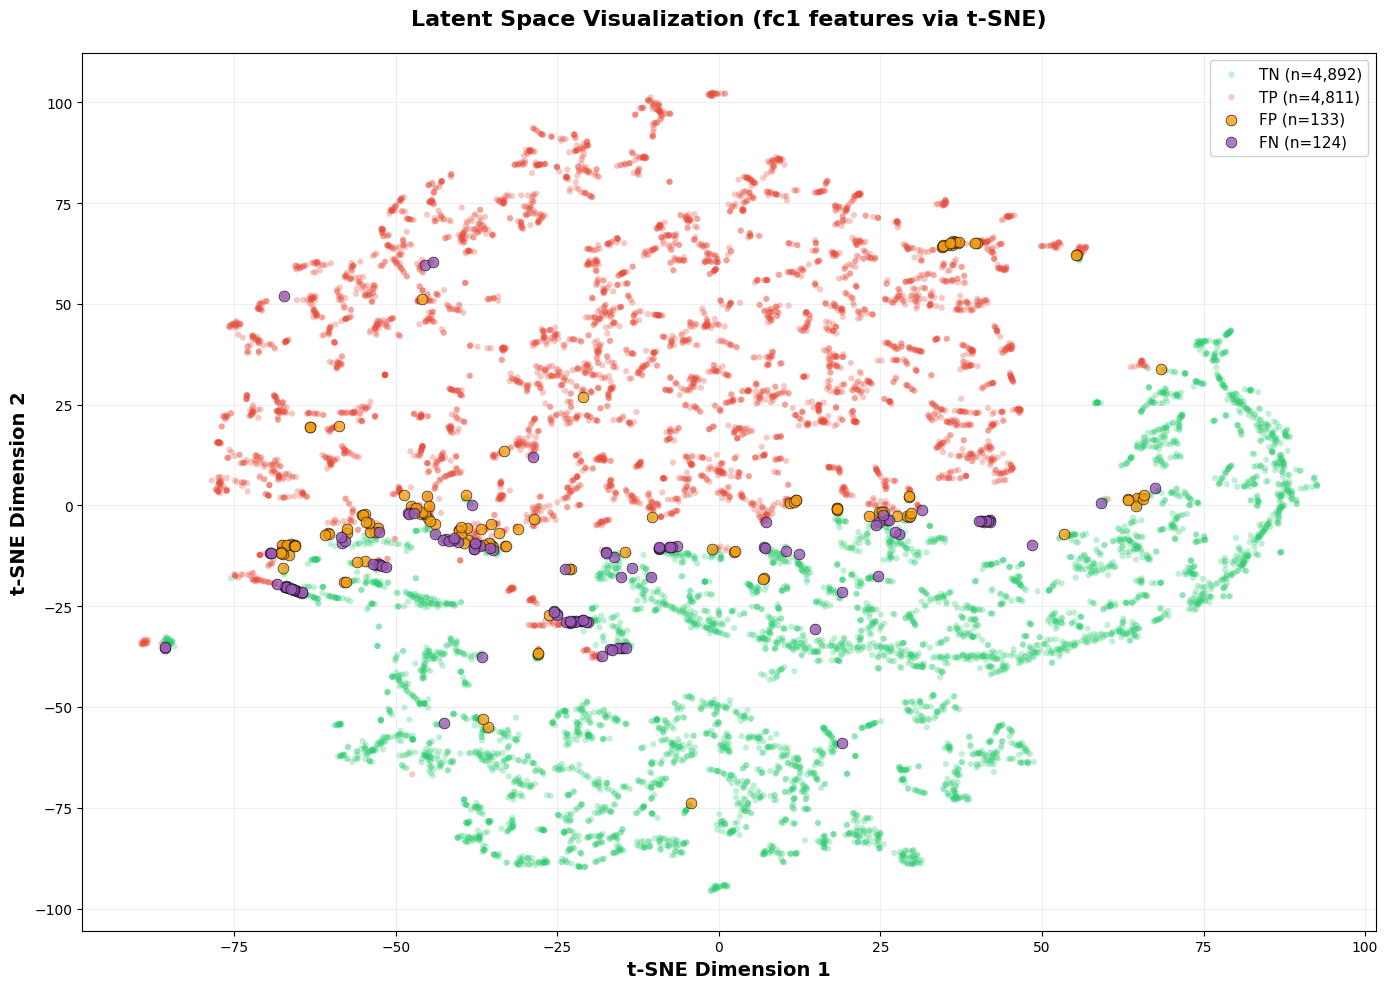

✅ Visualization complete!


In [ ]:
print("\n📊 Creating latent space visualization...")

# Create figure with larger size for clarity
plt.figure(figsize=(14, 10))

# Plot each category separately so we can control order and legend
for category in ['TN', 'TP', 'FP', 'FN']:
    # Get indices for this category
    mask = categories == category

    # Get 2D coordinates for this category
    x_coords = fc1_2d[mask, 0]  # x-axis values
    y_coords = fc1_2d[mask, 1]  # y-axis values

    # Determine point size and transparency
    if category in ['TN', 'TP']:
        # Correct predictions: smaller, more transparent
        alpha = 0.3
        size = 20
        zorder = 1  # Plot these first (in background)
    else:
        # Errors: larger, more opaque, on top
        alpha = 0.8
        size = 60
        zorder = 2  # Plot these on top

    # Create scatter plot for this category
    plt.scatter(
        x_coords,
        y_coords,
        c=color_map[category],  # Color from our color_map
        label=f'{category} (n={mask.sum():,})',  # Legend label with count
        alpha=alpha,  # Transparency
        s=size,       # Point size
        edgecolors='black' if category in ['FP', 'FN'] else 'none',  # Highlight errors
        linewidths=0.5,
        zorder=zorder
    )

# Add labels and title
plt.xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
plt.title('Latent Space Visualization (fc1 features via t-SNE)',
          fontsize=16, fontweight='bold', pad=20)

# Add legend
plt.legend(loc='best', fontsize=11, framealpha=0.9)

# Add grid for easier reading
plt.grid(True, alpha=0.2)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

print("✅ Visualization complete!")

Excellent! Let me analyze these plots for you. This reveals A LOT about your model's performance.

🔍 PLOT 1 ANALYSIS: Category-Based Visualization
What I See:
1. Clear Cluster Separation ✅✅✅

Green cluster (Real images): Bottom and right side
Red cluster (Fake images): Top and left-center
Clear gap between them: Yes! The clusters are well-separated

Interpretation:

Your model successfully learned discriminative features
Real vs. Fake have distinct internal representations
This is excellent news - the model isn't just guessing!


2. Error Distribution (Yellow & Purple dots)
False Positives (Yellow/Orange - Real→Fake):

Location: Mostly at the boundary between green and red clusters
Count: 133 samples
Pattern: Scattered along the transition zone between clusters

False Negatives (Purple - Fake→Real):

Location: Also mostly at the boundary between clusters
Count: 124 samples
Pattern: Similar to FP - near the decision boundary

Interpretation:

✅ This is the BEST case scenario!
Errors occur at the boundary between clusters (ambiguous region)
Very few errors are deep inside the wrong cluster
These are genuinely difficult/edge cases, not systematic failures

----------

3. What This Tells You:
The Good:

✅ Model learned meaningful features (clusters are separated)
✅ Errors are boundary cases (not confident mistakes)
✅ No major sub-clustering (no hidden subtypes causing problems)
✅ Errors are evenly distributed (no systematic bias)

What's Happening:

Some real images have fake-like features → End up near fake cluster
Some fake images are high-quality → End up near real cluster
The model correctly identifies "clearly real" and "clearly fake"
It struggles only with ambiguous cases in between

## Cell 8.7: Create Confidence Overlay Visualization


📊 Creating confidence-based visualization...


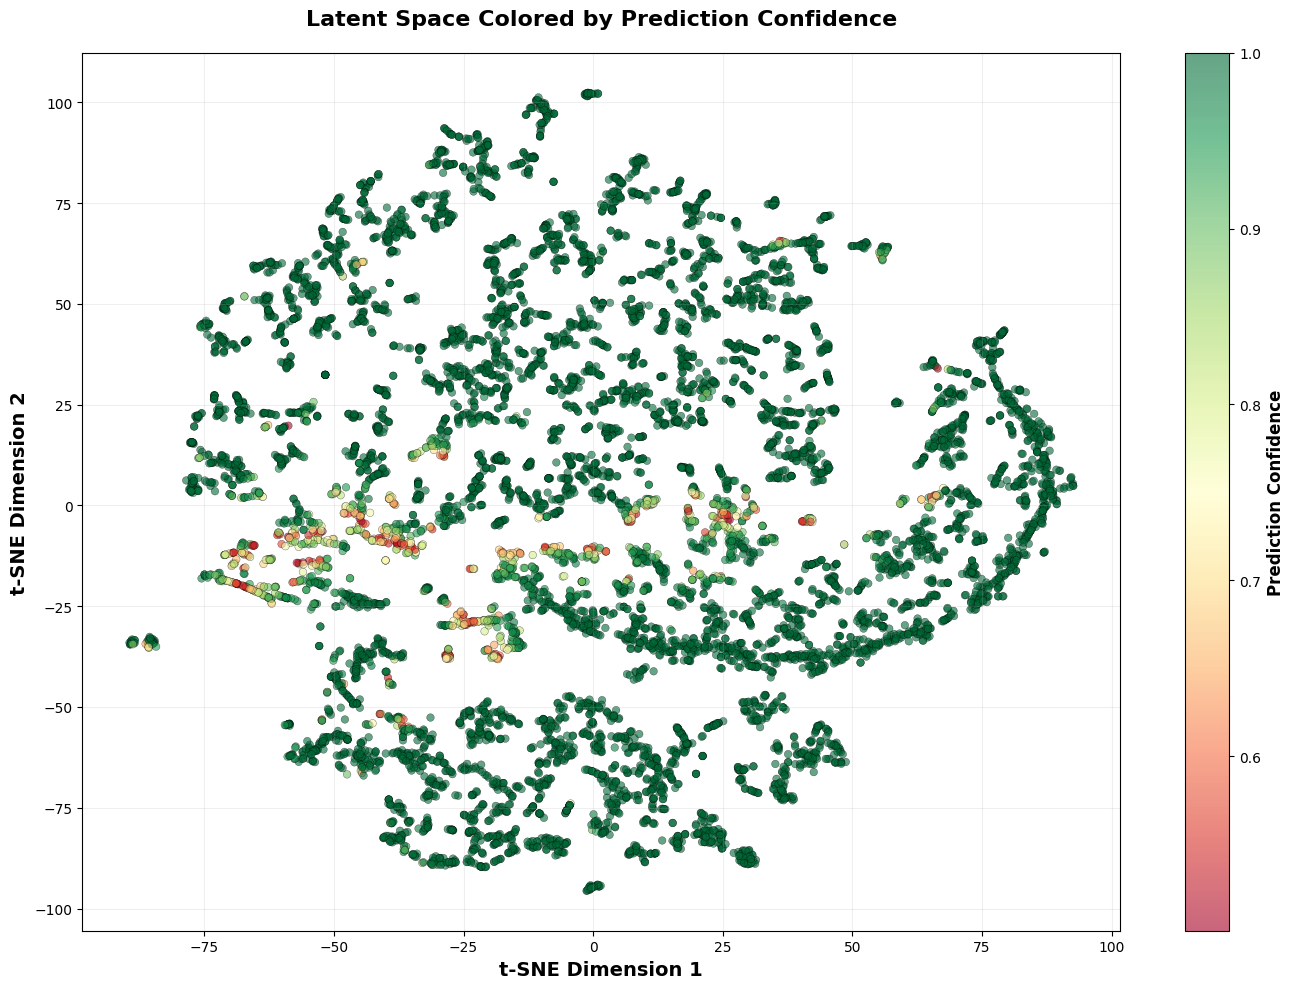

✅ Confidence visualization complete!

💡 Interpretation:
   🟢 Green  = High confidence predictions (>80%)
   🟡 Yellow = Medium confidence (50-80%)
   🔴 Red    = Low confidence predictions (<50%)


In [ ]:
print("\n📊 Creating confidence-based visualization...")

# Create figure
plt.figure(figsize=(14, 10))

# For each point, get the confidence of the PREDICTED class
confidences = np.zeros(len(all_predictions))
for i in range(len(all_predictions)):
    pred_class = all_predictions[i]
    confidences[i] = all_probs[i, pred_class]  # Confidence in predicted class

# Create scatter plot with confidence-based coloring
scatter = plt.scatter(
    fc1_2d[:, 0],  # x coordinates
    fc1_2d[:, 1],  # y coordinates
    c=confidences,  # Color based on confidence
    cmap='RdYlGn',  # Red (low) → Yellow (medium) → Green (high)
    s=30,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.3
)

# Add colorbar to show confidence scale
cbar = plt.colorbar(scatter, label='Prediction Confidence')
cbar.set_label('Prediction Confidence', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
plt.title('Latent Space Colored by Prediction Confidence',
          fontsize=16, fontweight='bold', pad=20)

# Add grid
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print("✅ Confidence visualization complete!")
print("\n💡 Interpretation:")
print("   🟢 Green  = High confidence predictions (>80%)")
print("   🟡 Yellow = Medium confidence (50-80%)")
print("   🔴 Red    = Low confidence predictions (<50%)")

## Cell 8.8: Analysis and Interpretation


In [ ]:
print("\n" + "="*60)
print("🔍 LATENT SPACE ANALYSIS")
print("="*60)

# Calculate some useful statistics

# 1. Error clustering
print("\n📍 Error Distribution:")

# Get 2D coordinates of errors
fp_coords = fc1_2d[categories == 'FP']
fn_coords = fc1_2d[categories == 'FN']

if len(fp_coords) > 0:
    # Calculate spread of false positives
    fp_std = np.std(fp_coords, axis=0)
    print(f"\n   False Positives (Real→Fake):")
    print(f"   • Count: {len(fp_coords):,}")
    print(f"   • Spread (std): X={fp_std[0]:.2f}, Y={fp_std[1]:.2f}")
    print(f"   • {'Clustered together' if fp_std.mean() < 5 else 'Scattered widely'}")

if len(fn_coords) > 0:
    # Calculate spread of false negatives
    fn_std = np.std(fn_coords, axis=0)
    print(f"\n   False Negatives (Fake→Real):")
    print(f"   • Count: {len(fn_coords):,}")
    print(f"   • Spread (std): X={fn_std[0]:.2f}, Y={fn_std[1]:.2f}")
    print(f"   • {'Clustered together' if fn_std.mean() < 5 else 'Scattered widely'}")

# 2. Confidence analysis
print("\n🎯 Confidence Analysis:")

# Average confidence for each category
for category in ['TN', 'TP', 'FP', 'FN']:
    mask = categories == category
    avg_conf = confidences[mask].mean()

    print(f"\n   {category}:")
    print(f"   • Average confidence: {avg_conf:.3f} ({avg_conf*100:.1f}%)")

    if category in ['FP', 'FN']:
        if avg_conf < 0.6:
            print(f"   • ✅ Low confidence errors (model is uncertain)")
        elif avg_conf < 0.8:
            print(f"   • ⚠️ Medium confidence errors (some uncertainty)")
        else:
            print(f"   • 🚨 High confidence errors (model is confidently wrong!)")

# 3. What to look for in the plot
print("\n\n💡 What to Look For in the Visualization:")
print("="*60)
print("""
1. CLUSTER SEPARATION:
   ✅ Good: Clear gap between green (real) and red (fake) clusters
   ⚠️ Problem: Green and red points heavily mixed

2. ERROR LOCATION:
   ✅ Good: Yellow/purple dots near cluster boundary
   ⚠️ Problem: Yellow/purple dots deep inside wrong cluster

3. SUB-CLUSTERS:
   ✅ Interesting: Multiple groups within green or red
   → Indicates different types of reals/fakes

4. CONFIDENCE PATTERN (2nd plot):
   ✅ Good: Cluster centers are green (high confidence)
   ✅ Good: Cluster boundaries are red/yellow (low confidence)
   ⚠️ Problem: Red dots (low confidence) scattered everywhere

5. ERROR CLUSTERING:
   ✅ Good: Errors form small clusters (specific failure modes)
   ⚠️ Problem: Errors scattered randomly (model confused)
""")

print("\n✅ Analysis complete! Check the plots above.")


🔍 LATENT SPACE ANALYSIS

📍 Error Distribution:

   False Positives (Real→Fake):
   • Count: 133
   • Spread (std): X=42.36, Y=27.45
   • Scattered widely

   False Negatives (Fake→Real):
   • Count: 124
   • Spread (std): X=34.66, Y=16.23
   • Scattered widely

🎯 Confidence Analysis:

   TN:
   • Average confidence: 0.978 (97.8%)

   TP:
   • Average confidence: 0.981 (98.1%)

   FP:
   • Average confidence: 0.727 (72.7%)
   • ⚠️ Medium confidence errors (some uncertainty)

   FN:
   • Average confidence: 0.703 (70.3%)
   • ⚠️ Medium confidence errors (some uncertainty)


💡 What to Look For in the Visualization:

1. CLUSTER SEPARATION:
   ✅ Good: Clear gap between green (real) and red (fake) clusters
   ⚠️ Problem: Green and red points heavily mixed
   
2. ERROR LOCATION:
   ✅ Good: Yellow/purple dots near cluster boundary
   ⚠️ Problem: Yellow/purple dots deep inside wrong cluster
   
3. SUB-CLUSTERS:
   ✅ Interesting: Multiple groups within green or red
   → Indicates different type

---

# Section 9: Interactive 3D Latent Space Visualization

## Cell 9.1: Install Plotly (if needed)

In [ ]:
# Install plotly if not already installed
!pip install -q plotly

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

print("✅ Plotly installed and imported!")

✅ Plotly installed and imported!


## Cell 9.2: Apply t-SNE with 3 Components

In [ ]:
print("\n" + "="*60)
print("🔄 APPLYING 3D t-SNE")
print("="*60)

print("\n⏳ Running t-SNE dimensionality reduction to 3D...")
print("   (This may take 3-7 minutes...)")

# Configure t-SNE for 3D
tsne_3d = TSNE(
    n_components=3,          # Output 3 dimensions (x, y, z)
    perplexity=30,           # Balance between local and global structure
    n_iter=1000,             # Number of optimization iterations
    random_state=RANDOM_SEED,  # Reproducibility
    verbose=1                # Show progress
)

# Apply t-SNE to our 128-D features
# Input: (9960, 128) → Output: (9960, 3)
start_time = time.time()
fc1_3d = tsne_3d.fit_transform(all_fc1_features)
elapsed = time.time() - start_time

print(f"\n✅ 3D t-SNE complete in {elapsed:.2f} seconds!")
print(f"   Original dimensions: {all_fc1_features.shape[1]}-D (fc1 features)")
print(f"   Reduced dimensions: {fc1_3d.shape[1]}-D (for 3D visualization)")
print(f"   Output shape: {fc1_3d.shape}")

# Extract x, y, z coordinates
x_coords = fc1_3d[:, 0]
y_coords = fc1_3d[:, 1]
z_coords = fc1_3d[:, 2]

print(f"\n📊 Coordinate ranges:")
print(f"   X: [{x_coords.min():.2f}, {x_coords.max():.2f}]")
print(f"   Y: [{y_coords.min():.2f}, {y_coords.max():.2f}]")
print(f"   Z: [{z_coords.min():.2f}, {z_coords.max():.2f}]")


🔄 APPLYING 3D t-SNE

⏳ Running t-SNE dimensionality reduction to 3D...
   (This may take 3-7 minutes...)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9960 samples in 0.001s...
[t-SNE] Computed neighbors for 9960 samples in 3.467s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9960
[t-SNE] Computed conditional probabilities for sample 2000 / 9960
[t-SNE] Computed conditional probabilities for sample 3000 / 9960
[t-SNE] Computed conditional probabilities for sample 4000 / 9960
[t-SNE] Computed conditional probabilities for sample 5000 / 9960
[t-SNE] Computed conditional probabilities for sample 6000 / 9960
[t-SNE] Computed conditional probabilities for sample 7000 / 9960
[t-SNE] Computed conditional probabilities for sample 8000 / 9960
[t-SNE] Computed conditional probabilities for sample 9000 / 9960
[t-SNE] Computed conditional probabilities for sample 9960 / 9960
[t-SNE] Mean sigma: 0.728546
[t-SNE] KL divergence after 250 iterations with early exaggerati


## Cell 9.3: Prepare Data for Plotly

In [ ]:
print("\n🎨 Preparing data for interactive visualization...")

# Create a list to store data for each category
plot_data = []

# Define category names and colors (same as before)
category_info = {
    'TN': {
        'name': 'True Negatives (Real→Real)',
        'color': 'rgb(46, 204, 113)',  # Green
        'symbol': 'circle',
        'size': 3
    },
    'TP': {
        'name': 'True Positives (Fake→Fake)',
        'color': 'rgb(231, 76, 60)',   # Red
        'symbol': 'circle',
        'size': 3
    },
    'FP': {
        'name': 'False Positives (Real→Fake)',
        'color': 'rgb(243, 156, 18)',  # Orange/Yellow
        'symbol': 'diamond',
        'size': 6
    },
    'FN': {
        'name': 'False Negatives (Fake→Real)',
        'color': 'rgb(155, 89, 182)',  # Purple
        'symbol': 'diamond',
        'size': 6
    }
}

# For each category, create a separate trace (for better legend control)
for category in ['TN', 'TP', 'FP', 'FN']:
    # Get mask for this category
    mask = categories == category

    # Get coordinates for this category
    cat_x = x_coords[mask]
    cat_y = y_coords[mask]
    cat_z = z_coords[mask]

    # Get confidence scores for hover info
    cat_confidences = confidences[mask]

    # Get indices (for reference)
    cat_indices = np.where(mask)[0]

    # Create hover text with detailed info
    hover_texts = []
    for i, idx in enumerate(cat_indices):
        hover_text = (
            f"<b>Category:</b> {category}<br>"
            f"<b>Index:</b> {idx}<br>"
            f"<b>True Label:</b> {'Real' if all_labels[idx] == 0 else 'Fake'}<br>"
            f"<b>Predicted:</b> {'Real' if all_predictions[idx] == 0 else 'Fake'}<br>"
            f"<b>Confidence:</b> {cat_confidences[i]:.3f} ({cat_confidences[i]*100:.1f}%)<br>"
            f"<b>Coordinates:</b> ({cat_x[i]:.2f}, {cat_y[i]:.2f}, {cat_z[i]:.2f})"
        )
        hover_texts.append(hover_text)

    # Create 3D scatter trace for this category
    trace = go.Scatter3d(
        x=cat_x,
        y=cat_y,
        z=cat_z,
        mode='markers',
        name=f"{category} (n={mask.sum():,})",
        marker=dict(
            size=category_info[category]['size'],
            color=category_info[category]['color'],
            symbol=category_info[category]['symbol'],
            opacity=0.8 if category in ['FP', 'FN'] else 0.4,  # Errors more opaque
            line=dict(
                color='black' if category in ['FP', 'FN'] else 'rgba(0,0,0,0)',
                width=0.5
            )
        ),
        text=hover_texts,
        hovertemplate='%{text}<extra></extra>',  # Custom hover template
        showlegend=True
    )

    plot_data.append(trace)

print(f"✅ Prepared {len(plot_data)} traces (one per category)")


🎨 Preparing data for interactive visualization...
✅ Prepared 4 traces (one per category)


## Cell 9.4: Create Interactive 3D Plot


In [ ]:
print("\n📊 Creating interactive 3D visualization...")

# Create figure with all traces
fig = go.Figure(data=plot_data)

# Update layout for better appearance
fig.update_layout(
    title={
        'text': '<b>Interactive 3D Latent Space Visualization</b><br>'
                '<sub>fc1 features (128-D) → t-SNE (3-D)</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    scene=dict(
        xaxis=dict(
            title='<b>t-SNE Dimension 1</b>',
            backgroundcolor="rgb(230, 230, 230)",
            gridcolor="white",
            showbackground=True,
        ),
        yaxis=dict(
            title='<b>t-SNE Dimension 2</b>',
            backgroundcolor="rgb(230, 230, 230)",
            gridcolor="white",
            showbackground=True,
        ),
        zaxis=dict(
            title='<b>t-SNE Dimension 3</b>',
            backgroundcolor="rgb(230, 230, 230)",
            gridcolor="white",
            showbackground=True,
        ),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)  # Initial viewing angle
        )
    ),
    legend=dict(
        title="<b>Categories</b>",
        font=dict(size=11),
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1
    ),
    width=1000,
    height=800,
    hovermode='closest'
)

# Show the plot
fig.show()

print("\n✅ Interactive 3D plot created!")
print("\n💡 How to interact with the plot:")
print("   🖱️  Click and drag to ROTATE the view")
print("   🔍 Scroll to ZOOM in/out")
print("   👆 Hover over points to see detailed information")
print("   👁️  Click legend items to TOGGLE categories on/off")
print("   📸 Use camera icon (top-right) to save as PNG")
print("   🏠 Click 'Reset axes' to return to original view")

Output hidden; open in https://colab.research.google.com to view.

## Cell 9.5: Create Confidence-Based 3D Visualization


In [ ]:
print("\n📊 Creating confidence-based 3D visualization...")

# Create scatter plot colored by confidence
fig_confidence = go.Figure()

# Add single trace with all points, colored by confidence
fig_confidence.add_trace(
    go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        marker=dict(
            size=4,
            color=confidences,  # Color based on confidence values
            colorscale='RdYlGn',  # Red (low) → Yellow → Green (high)
            cmin=0.5,  # Minimum confidence for color scale
            cmax=1.0,  # Maximum confidence for color scale
            colorbar=dict(
                title="<b>Prediction<br>Confidence</b>",
                titleside="right",
                tickmode="linear",
                tick0=0.5,
                dtick=0.1,
                thickness=20,
                len=0.7
            ),
            opacity=0.6,
            line=dict(color='black', width=0.2)
        ),
        text=[
            f"Confidence: {conf:.3f} ({conf*100:.1f}%)<br>"
            f"Category: {cat}<br>"
            f"True: {'Real' if all_labels[i]==0 else 'Fake'}<br>"
            f"Pred: {'Real' if all_predictions[i]==0 else 'Fake'}"
            for i, (conf, cat) in enumerate(zip(confidences, categories))
        ],
        hovertemplate='%{text}<extra></extra>',
        showlegend=False
    )
)

# Update layout
fig_confidence.update_layout(
    title={
        'text': '<b>3D Latent Space Colored by Prediction Confidence</b><br>'
                '<sub>Green = High confidence | Yellow = Medium | Red = Low</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    scene=dict(
        xaxis=dict(
            title='<b>t-SNE Dimension 1</b>',
            backgroundcolor="rgb(230, 230, 230)",
            gridcolor="white",
            showbackground=True,
        ),
        yaxis=dict(
            title='<b>t-SNE Dimension 2</b>',
            backgroundcolor="rgb(230, 230, 230)",
            gridcolor="white",
            showbackground=True,
        ),
        zaxis=dict(
            title='<b>t-SNE Dimension 3</b>',
            backgroundcolor="rgb(230, 230, 230)",
            gridcolor="white",
            showbackground=True,
        ),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1000,
    height=800,
    hovermode='closest'
)

# Show the plot
fig_confidence.show()

print("\n✅ Confidence-based 3D plot created!")


📊 Creating confidence-based 3D visualization...



✅ Confidence-based 3D plot created!


## Cell 9.6: Side-by-Side Comparison (Optional - Advanced)


In [ ]:
print("\n📊 Creating side-by-side comparison...")

# Create subplot with 2 columns
from plotly.subplots import make_subplots

fig_comparison = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=(
        '<b>Colored by Category</b>',
        '<b>Colored by Confidence</b>'
    ),
    horizontal_spacing=0.05
)

# Add category-based traces to left subplot
for trace in plot_data:
    fig_comparison.add_trace(trace, row=1, col=1)

# Add confidence-based trace to right subplot
fig_comparison.add_trace(
    go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        marker=dict(
            size=4,
            color=confidences,
            colorscale='RdYlGn',
            cmin=0.5,
            cmax=1.0,
            colorbar=dict(
                title="<b>Confidence</b>",
                x=1.15,  # Position colorbar to the right
                thickness=15,
                len=0.5
            ),
            opacity=0.6,
            line=dict(color='black', width=0.2)
        ),
        showlegend=False
    ),
    row=1, col=2
)

# Update layout for both subplots
fig_comparison.update_layout(
    title={
        'text': '<b>3D Latent Space - Dual View</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 22}
    },
    width=1800,
    height=800,
    showlegend=True
)

# Update scene properties for both subplots
for i in [1, 2]:
    fig_comparison.update_scenes(
        dict(
            xaxis=dict(
                title='t-SNE-1',
                backgroundcolor="rgb(230, 230, 230)",
                gridcolor="white",
                showbackground=True
            ),
            yaxis=dict(
                title='t-SNE-2',
                backgroundcolor="rgb(230, 230, 230)",
                gridcolor="white",
                showbackground=True
            ),
            zaxis=dict(
                title='t-SNE-3',
                backgroundcolor="rgb(230, 230, 230)",
                gridcolor="white",
                showbackground=True
            ),
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
        ),
        row=1, col=i
    )

fig_comparison.show()

print("\n✅ Side-by-side comparison created!")
print("\n💡 Both views show the SAME 3D space from the SAME angle")
print("   Left: Category-based coloring (TN/TP/FP/FN)")
print("   Right: Confidence-based coloring")

Output hidden; open in https://colab.research.google.com to view.

---

# PART 1: IMAGE STATISTICS ANALYSIS

# Section 10: Image Statistics Analysis

## Cell 10.1: Import Additional Libraries

In [ ]:
# Import libraries for image processing and statistics
import cv2
from scipy import ndimage
from scipy.stats import ttest_ind

print("✅ Additional libraries imported for image statistics!")

✅ Additional libraries imported for image statistics!


## Cell 10.2: Define Metric Functions

In [ ]:
print("\n" + "="*60)
print("📐 DEFINING IMAGE METRIC FUNCTIONS")
print("="*60)

def calculate_sharpness(image_tensor):
    """
    Calculate sharpness using Laplacian variance

    Args:
        image_tensor: PyTorch tensor (C, H, W) in range [0, 1]

    Returns:
        float: Sharpness score (higher = sharper)
    """
    # Convert tensor to numpy and scale to [0, 255]
    img = image_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img = (img * 255).astype(np.uint8)

    # Convert to grayscale for Laplacian
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate Laplacian (measures edges/sharpness)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Variance of Laplacian = sharpness score
    sharpness = laplacian.var()

    return sharpness


def calculate_brightness(image_tensor):
    """
    Calculate average brightness

    Args:
        image_tensor: PyTorch tensor (C, H, W) in range [0, 1]

    Returns:
        float: Brightness score in range [0, 1]
    """
    # Mean of all pixel values
    brightness = image_tensor.mean().item()

    return brightness


def calculate_contrast(image_tensor):
    """
    Calculate contrast using standard deviation

    Args:
        image_tensor: PyTorch tensor (C, H, W) in range [0, 1]

    Returns:
        float: Contrast score
    """
    # Standard deviation of pixel values
    contrast = image_tensor.std().item()

    return contrast


def calculate_frequency_content(image_tensor):
    """
    Calculate high-frequency content using FFT

    Args:
        image_tensor: PyTorch tensor (C, H, W) in range [0, 1]

    Returns:
        float: Ratio of high-frequency energy to total energy
    """
    # Convert to grayscale numpy array
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Apply 2D FFT (Fast Fourier Transform)
    fft = np.fft.fft2(gray)
    fft_shift = np.fft.fftshift(fft)  # Shift zero frequency to center

    # Calculate magnitude spectrum
    magnitude = np.abs(fft_shift)

    # Define high-frequency region (outer 40% of spectrum)
    h, w = gray.shape
    center_h, center_w = h // 2, w // 2

    # Create mask for high frequencies (exclude center 60%)
    y, x = np.ogrid[:h, :w]
    mask_radius = min(center_h, center_w) * 0.6
    mask = ((x - center_w)**2 + (y - center_h)**2) > mask_radius**2

    # Calculate energy in high vs. total frequencies
    high_freq_energy = np.sum(magnitude[mask])
    total_energy = np.sum(magnitude)

    # Ratio of high-frequency to total energy
    high_freq_ratio = high_freq_energy / (total_energy + 1e-10)  # Avoid division by zero

    return high_freq_ratio


print("✅ Metric functions defined:")
print("   • calculate_sharpness() - Laplacian variance")
print("   • calculate_brightness() - Mean pixel intensity")
print("   • calculate_contrast() - Std dev of pixels")
print("   • calculate_frequency_content() - High-freq FFT ratio")


📐 DEFINING IMAGE METRIC FUNCTIONS
✅ Metric functions defined:
   • calculate_sharpness() - Laplacian variance
   • calculate_brightness() - Mean pixel intensity
   • calculate_contrast() - Std dev of pixels
   • calculate_frequency_content() - High-freq FFT ratio


## Cell 10.3: Compute Metrics for All Test Images

In [ ]:
print("\n" + "="*60)
print("🔢 COMPUTING METRICS FOR ALL TEST IMAGES")
print("="*60)

print(f"\n⏳ Processing {len(X_test):,} test images...")
print("   This will take 2-5 minutes...")

# Storage for metrics
sharpness_scores = []
brightness_scores = []
contrast_scores = []
frequency_scores = []

# Process each test image
start_time = time.time()

for i in tqdm(range(len(X_test)), desc="Computing metrics"):
    img_tensor = X_test[i]  # Shape: (3, 64, 64)

    # Calculate all metrics
    sharpness = calculate_sharpness(img_tensor)
    brightness = calculate_brightness(img_tensor)
    contrast = calculate_contrast(img_tensor)
    frequency = calculate_frequency_content(img_tensor)

    # Store
    sharpness_scores.append(sharpness)
    brightness_scores.append(brightness)
    contrast_scores.append(contrast)
    frequency_scores.append(frequency)

elapsed = time.time() - start_time

# Convert to numpy arrays
sharpness_scores = np.array(sharpness_scores)
brightness_scores = np.array(brightness_scores)
contrast_scores = np.array(contrast_scores)
frequency_scores = np.array(frequency_scores)

print(f"\n✅ Metrics computed in {elapsed:.2f} seconds!")
print(f"\n📊 Metric Ranges:")
print(f"   Sharpness:  [{sharpness_scores.min():.2f}, {sharpness_scores.max():.2f}]")
print(f"   Brightness: [{brightness_scores.min():.3f}, {brightness_scores.max():.3f}]")
print(f"   Contrast:   [{contrast_scores.min():.3f}, {contrast_scores.max():.3f}]")
print(f"   Frequency:  [{frequency_scores.min():.3f}, {frequency_scores.max():.3f}]")


🔢 COMPUTING METRICS FOR ALL TEST IMAGES

⏳ Processing 9,960 test images...
   This will take 2-5 minutes...


Computing metrics: 100%|██████████| 9960/9960 [00:18<00:00, 546.55it/s]


✅ Metrics computed in 18.23 seconds!

📊 Metric Ranges:
   Sharpness:  [382.13, 11126.67]
   Brightness: [0.122, 0.898]
   Contrast:   [0.100, 0.387]
   Frequency:  [0.207, 0.445]


## Cell 10.4: Group Metrics by Category

In [ ]:
print("\n" + "="*60)
print("📊 GROUPING METRICS BY CATEGORY")
print("="*60)

# Group metrics by category (TN, TP, FP, FN)
metrics_by_category = {
    'TN': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []},
    'TP': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []},
    'FP': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []},
    'FN': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []}
}

# Populate dictionary
for i in range(len(categories)):
    cat = categories[i]
    metrics_by_category[cat]['sharpness'].append(sharpness_scores[i])
    metrics_by_category[cat]['brightness'].append(brightness_scores[i])
    metrics_by_category[cat]['contrast'].append(contrast_scores[i])
    metrics_by_category[cat]['frequency'].append(frequency_scores[i])

# Convert lists to numpy arrays
for cat in ['TN', 'TP', 'FP', 'FN']:
    for metric in ['sharpness', 'brightness', 'contrast', 'frequency']:
        metrics_by_category[cat][metric] = np.array(metrics_by_category[cat][metric])

print("✅ Metrics grouped by category")
print(f"\n📊 Samples per category:")
for cat in ['TN', 'TP', 'FP', 'FN']:
    count = len(metrics_by_category[cat]['sharpness'])
    print(f"   {cat}: {count:,}")


📊 GROUPING METRICS BY CATEGORY
✅ Metrics grouped by category

📊 Samples per category:
   TN: 4,892
   TP: 4,811
   FP: 133
   FN: 124


## Cell 10.5: Calculate Statistics and Create Comparison Table


In [ ]:
print("\n" + "="*60)
print("📈 STATISTICAL COMPARISON")
print("="*60)

# Calculate mean and std for each metric per category
stats_table = []

for metric in ['sharpness', 'brightness', 'contrast', 'frequency']:
    print(f"\n{'='*60}")
    print(f"📊 {metric.upper()} ANALYSIS")
    print(f"{'='*60}")

    row = {'Metric': metric.capitalize()}

    for cat in ['TN', 'TP', 'FP', 'FN']:
        data = metrics_by_category[cat][metric]
        mean_val = np.mean(data)
        std_val = np.std(data)

        row[f'{cat}_mean'] = mean_val
        row[f'{cat}_std'] = std_val

        # Description
        if cat == 'TN':
            desc = "Correct Reals"
        elif cat == 'TP':
            desc = "Correct Fakes"
        elif cat == 'FP':
            desc = "Real→Fake (Error)"
        else:
            desc = "Fake→Real (Error)"

        print(f"\n{cat} ({desc}):")
        print(f"   Mean: {mean_val:.4f}")
        print(f"   Std:  {std_val:.4f}")

    stats_table.append(row)

    # Statistical significance tests
    print(f"\n🔬 Statistical Tests:")

    # Compare FP vs TN (are false positives different from correct reals?)
    fp_data = metrics_by_category['FP'][metric]
    tn_data = metrics_by_category['TN'][metric]

    if len(fp_data) > 0 and len(tn_data) > 0:
        t_stat, p_value = ttest_ind(fp_data, tn_data)
        print(f"   FP vs TN: t={t_stat:.3f}, p={p_value:.4f}", end="")
        if p_value < 0.001:
            print(" *** (Highly significant difference!)")
        elif p_value < 0.05:
            print(" ** (Significant difference)")
        elif p_value < 0.1:
            print(" * (Marginally significant)")
        else:
            print(" (No significant difference)")

    # Compare FN vs TP (are false negatives different from correct fakes?)
    fn_data = metrics_by_category['FN'][metric]
    tp_data = metrics_by_category['TP'][metric]

    if len(fn_data) > 0 and len(tp_data) > 0:
        t_stat, p_value = ttest_ind(fn_data, tp_data)
        print(f"   FN vs TP: t={t_stat:.3f}, p={p_value:.4f}", end="")
        if p_value < 0.001:
            print(" *** (Highly significant difference!)")
        elif p_value < 0.05:
            print(" ** (Significant difference)")
        elif p_value < 0.1:
            print(" * (Marginally significant)")
        else:
            print(" (No significant difference)")

print("\n" + "="*60)
print("✅ Statistical analysis complete!")


📈 STATISTICAL COMPARISON

📊 SHARPNESS ANALYSIS

TN (Correct Reals):
   Mean: 3278.6577
   Std:  1713.4177

TP (Correct Fakes):
   Mean: 3298.8435
   Std:  1665.4311

FP (Real→Fake (Error)):
   Mean: 3278.1553
   Std:  1573.1661

FN (Fake→Real (Error)):
   Mean: 3653.5122
   Std:  1554.0906

🔬 Statistical Tests:
   FP vs TN: t=-0.003, p=0.9973 (No significant difference)
   FN vs TP: t=2.345, p=0.0191 ** (Significant difference)

📊 BRIGHTNESS ANALYSIS

TN (Correct Reals):
   Mean: 0.4121
   Std:  0.1405

TP (Correct Fakes):
   Mean: 0.4058
   Std:  0.1233

FP (Real→Fake (Error)):
   Mean: 0.3705
   Std:  0.0883

FN (Fake→Real (Error)):
   Mean: 0.4015
   Std:  0.1255

🔬 Statistical Tests:
   FP vs TN: t=-3.398, p=0.0007 *** (Highly significant difference!)
   FN vs TP: t=-0.383, p=0.7020 (No significant difference)

📊 CONTRAST ANALYSIS

TN (Correct Reals):
   Mean: 0.2356
   Std:  0.0514

TP (Correct Fakes):
   Mean: 0.2377
   Std:  0.0458

FP (Real→Fake (Error)):
   Mean: 0.2210
   St

## Cell 10.6: Visualize Distributions with Box Plots



📊 Creating distribution visualizations...


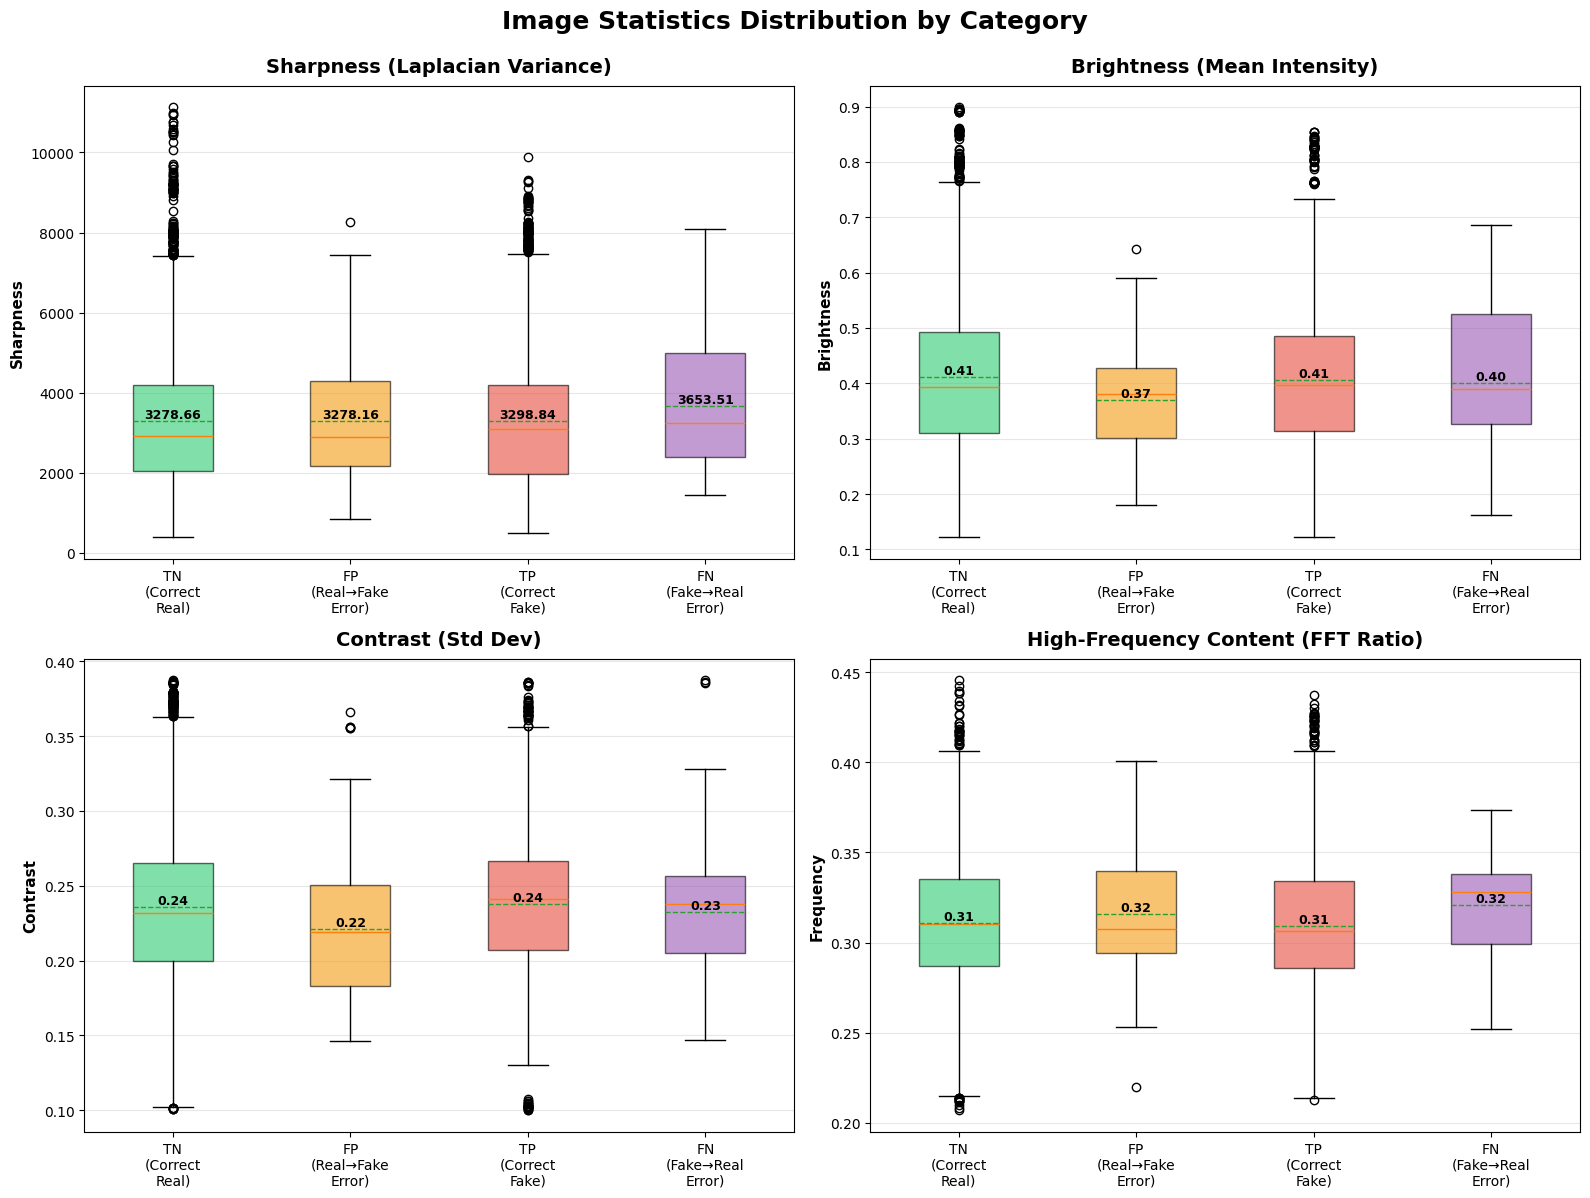

✅ Box plots created!


In [ ]:
print("\n📊 Creating distribution visualizations...")

# Create figure with 2x2 subplots (one for each metric)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics_list = ['sharpness', 'brightness', 'contrast', 'frequency']
metric_titles = ['Sharpness (Laplacian Variance)', 'Brightness (Mean Intensity)',
                 'Contrast (Std Dev)', 'High-Frequency Content (FFT Ratio)']

for idx, (metric, title) in enumerate(zip(metrics_list, metric_titles)):
    ax = axes[idx]

    # Prepare data for box plot
    data_to_plot = []
    labels = []
    colors_list = []

    for cat in ['TN', 'FP', 'TP', 'FN']:
        data_to_plot.append(metrics_by_category[cat][metric])

        if cat == 'TN':
            labels.append('TN\n(Correct\nReal)')
            colors_list.append('#2ecc71')
        elif cat == 'FP':
            labels.append('FP\n(Real→Fake\nError)')
            colors_list.append('#f39c12')
        elif cat == 'TP':
            labels.append('TP\n(Correct\nFake)')
            colors_list.append('#e74c3c')
        else:  # FN
            labels.append('FN\n(Fake→Real\nError)')
            colors_list.append('#9b59b6')

    # Create box plot
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Color the boxes
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    # Style
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel(metric.capitalize(), fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add mean values as text
    means = [np.mean(d) for d in data_to_plot]
    for i, mean in enumerate(means):
        ax.text(i+1, mean, f'{mean:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Image Statistics Distribution by Category',
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ Box plots created!")

## Cell 10.7: Create Histogram Comparisons



📊 Creating histogram comparisons...


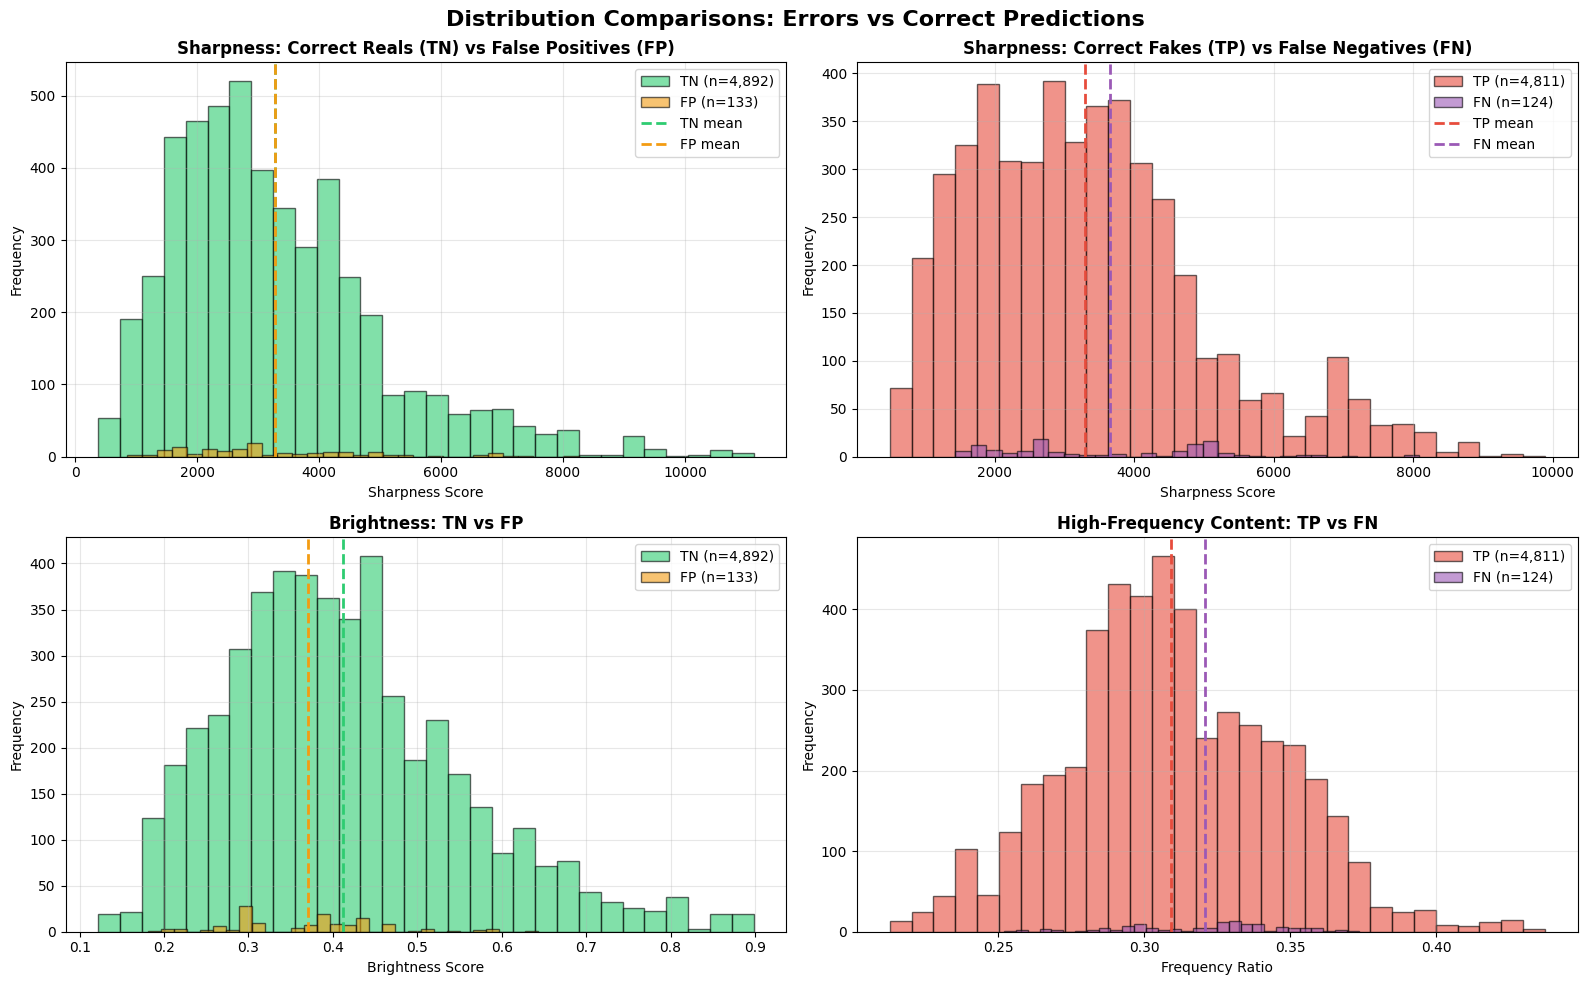

✅ Histograms created!


In [ ]:
print("\n📊 Creating histogram comparisons...")

# Focus on sharpness (usually most informative)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: TN vs FP (Real images: correct vs misclassified)
axes[0, 0].hist(metrics_by_category['TN']['sharpness'], bins=30, alpha=0.6,
                color='#2ecc71', label=f'TN (n={len(metrics_by_category["TN"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 0].hist(metrics_by_category['FP']['sharpness'], bins=30, alpha=0.6,
                color='#f39c12', label=f'FP (n={len(metrics_by_category["FP"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 0].axvline(np.mean(metrics_by_category['TN']['sharpness']),
                   color='#2ecc71', linestyle='--', linewidth=2, label='TN mean')
axes[0, 0].axvline(np.mean(metrics_by_category['FP']['sharpness']),
                   color='#f39c12', linestyle='--', linewidth=2, label='FP mean')
axes[0, 0].set_title('Sharpness: Correct Reals (TN) vs False Positives (FP)',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sharpness Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: TP vs FN (Fake images: correct vs misclassified)
axes[0, 1].hist(metrics_by_category['TP']['sharpness'], bins=30, alpha=0.6,
                color='#e74c3c', label=f'TP (n={len(metrics_by_category["TP"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 1].hist(metrics_by_category['FN']['sharpness'], bins=30, alpha=0.6,
                color='#9b59b6', label=f'FN (n={len(metrics_by_category["FN"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 1].axvline(np.mean(metrics_by_category['TP']['sharpness']),
                   color='#e74c3c', linestyle='--', linewidth=2, label='TP mean')
axes[0, 1].axvline(np.mean(metrics_by_category['FN']['sharpness']),
                   color='#9b59b6', linestyle='--', linewidth=2, label='FN mean')
axes[0, 1].set_title('Sharpness: Correct Fakes (TP) vs False Negatives (FN)',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sharpness Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Brightness comparison (TN vs FP)
axes[1, 0].hist(metrics_by_category['TN']['brightness'], bins=30, alpha=0.6,
                color='#2ecc71', label=f'TN (n={len(metrics_by_category["TN"]["brightness"]):,})',
                edgecolor='black')
axes[1, 0].hist(metrics_by_category['FP']['brightness'], bins=30, alpha=0.6,
                color='#f39c12', label=f'FP (n={len(metrics_by_category["FP"]["brightness"]):,})',
                edgecolor='black')
axes[1, 0].axvline(np.mean(metrics_by_category['TN']['brightness']),
                   color='#2ecc71', linestyle='--', linewidth=2)
axes[1, 0].axvline(np.mean(metrics_by_category['FP']['brightness']),
                   color='#f39c12', linestyle='--', linewidth=2)
axes[1, 0].set_title('Brightness: TN vs FP', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Brightness Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Frequency content (TP vs FN)
axes[1, 1].hist(metrics_by_category['TP']['frequency'], bins=30, alpha=0.6,
                color='#e74c3c', label=f'TP (n={len(metrics_by_category["TP"]["frequency"]):,})',
                edgecolor='black')
axes[1, 1].hist(metrics_by_category['FN']['frequency'], bins=30, alpha=0.6,
                color='#9b59b6', label=f'FN (n={len(metrics_by_category["FN"]["frequency"]):,})',
                edgecolor='black')
axes[1, 1].axvline(np.mean(metrics_by_category['TP']['frequency']),
                   color='#e74c3c', linestyle='--', linewidth=2)
axes[1, 1].axvline(np.mean(metrics_by_category['FN']['frequency']),
                   color='#9b59b6', linestyle='--', linewidth=2)
axes[1, 1].set_title('High-Frequency Content: TP vs FN', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Frequency Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Distribution Comparisons: Errors vs Correct Predictions',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Histograms created!")

## Cell 10.8: Summary and Interpretation


In [ ]:
print("\n" + "="*60)
print("🔍 IMAGE STATISTICS SUMMARY & INTERPRETATION")
print("="*60)

print("""
KEY QUESTIONS TO ANSWER:

1. FALSE POSITIVES (Real→Fake):
   Are FP images significantly BLURRIER/DARKER than TN (correct reals)?

   If YES:
   ❌ Model uses quality shortcuts
   ❌ Low-quality real images get flagged as fake
   → Solution: Quality-aware loss or data augmentation

   If NO:
   ✅ Model doesn't use simple quality heuristics
   ✅ Errors are content-based, not quality-based

2. FALSE NEGATIVES (Fake→Real):
   Are FN images significantly SHARPER/BRIGHTER than TP (correct fakes)?

   If YES:
   ❌ High-quality fakes fool the model
   ❌ Model learned "sharp = real"
   → Solution: Need to detect high-quality fakes better

   If NO:
   ✅ Quality doesn't explain why fakes fooled the model
   ✅ These fakes have other realistic features

3. FREQUENCY CONTENT:
   Do FN have higher high-frequency content than TP?

   If YES:
   🔍 These fakes preserved fine details well
   🔍 More sophisticated generation method
   → Solution: Frequency-aware loss

Look at the p-values above:
   p < 0.05 = Statistically significant difference
   p >= 0.05 = No significant difference
""")

# Provide automated interpretation based on p-values
print("\n📊 AUTOMATED INTERPRETATION:")
print("="*60)

# We'll check if FP are significantly different from TN in sharpness
fp_sharp = metrics_by_category['FP']['sharpness']
tn_sharp = metrics_by_category['TN']['sharpness']

if len(fp_sharp) > 0:
    t_stat, p_val = ttest_ind(fp_sharp, tn_sharp)
    fp_mean = np.mean(fp_sharp)
    tn_mean = np.mean(tn_sharp)

    print(f"\n🔍 False Positives vs Correct Reals (Sharpness):")
    print(f"   FP mean: {fp_mean:.2f}")
    print(f"   TN mean: {tn_mean:.2f}")
    print(f"   Difference: {fp_mean - tn_mean:.2f}")
    print(f"   p-value: {p_val:.4f}")

    if p_val < 0.05:
        if fp_mean < tn_mean:
            print(f"\n   ⚠️ FINDING: False positives are SIGNIFICANTLY BLURRIER")
            print(f"   ❌ Model likely uses blur as a cue for fake")
            print(f"   💡 Recommendation: Implement quality-aware loss")
        else:
            print(f"\n   🔍 FINDING: False positives are SHARPER (unusual)")
            print(f"   🤔 Unexpected pattern - investigate further")
    else:
        print(f"\n   ✅ FINDING: No significant quality difference")
        print(f"   ✅ Model doesn't use sharpness shortcuts")

# Check FN vs TP
fn_sharp = metrics_by_category['FN']['sharpness']
tp_sharp = metrics_by_category['TP']['sharpness']

if len(fn_sharp) > 0:
    t_stat, p_val = ttest_ind(fn_sharp, tp_sharp)
    fn_mean = np.mean(fn_sharp)
    tp_mean = np.mean(tp_sharp)

    print(f"\n🔍 False Negatives vs Correct Fakes (Sharpness):")
    print(f"   FN mean: {fn_mean:.2f}")
    print(f"   TP mean: {tp_mean:.2f}")
    print(f"   Difference: {fn_mean - tp_mean:.2f}")
    print(f"   p-value: {p_val:.4f}")

    if p_val < 0.05:
        if fn_mean > tp_mean:
            print(f"\n   ⚠️ FINDING: False negatives are SIGNIFICANTLY SHARPER")
            print(f"   ❌ High-quality fakes fool the model")
            print(f"   💡 Recommendation: Model needs better fake detection for sharp images")
        else:
            print(f"\n   🔍 FINDING: False negatives are BLURRIER (unusual)")
            print(f"   🤔 Unexpected pattern - investigate further")
    else:
        print(f"\n   ✅ FINDING: No significant quality difference")
        print(f"   ✅ Errors aren't explained by sharpness alone")

print(f"\n{'='*60}")
print("✅ Image statistics analysis complete!")
print(f"{'='*60}")


🔍 IMAGE STATISTICS SUMMARY & INTERPRETATION

KEY QUESTIONS TO ANSWER:

1. FALSE POSITIVES (Real→Fake):
   Are FP images significantly BLURRIER/DARKER than TN (correct reals)?
   
   If YES:
   ❌ Model uses quality shortcuts
   ❌ Low-quality real images get flagged as fake
   → Solution: Quality-aware loss or data augmentation
   
   If NO:
   ✅ Model doesn't use simple quality heuristics
   ✅ Errors are content-based, not quality-based

2. FALSE NEGATIVES (Fake→Real):
   Are FN images significantly SHARPER/BRIGHTER than TP (correct fakes)?
   
   If YES:
   ❌ High-quality fakes fool the model
   ❌ Model learned "sharp = real"
   → Solution: Need to detect high-quality fakes better
   
   If NO:
   ✅ Quality doesn't explain why fakes fooled the model
   ✅ These fakes have other realistic features

3. FREQUENCY CONTENT:
   Do FN have higher high-frequency content than TP?
   
   If YES:
   🔍 These fakes preserved fine details well
   🔍 More sophisticated generation method
   → Solution:

---

# PART 2: SALIENCY MAPS (Grad-CAM)

## Section 11: Grad-CAM Visualization

## Cell 11.1: Define Grad-CAM Class

In [ ]:
print("\n" + "="*60)
print("🔥 GRAD-CAM IMPLEMENTATION")
print("="*60)

class GradCAM:
    """
    Gradient-weighted Class Activation Mapping (Grad-CAM)

    Generates heatmaps showing which regions of the input image
    were most important for the model's prediction.
    """

    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM

        Args:
            model: The neural network model
            target_layer: The layer to compute gradients from (e.g., model.pool2)
        """
        self.model = model
        self.target_layer = target_layer

        # Storage for activations and gradients
        self.activations = None
        self.gradients = None

        # Register hooks to capture activations and gradients
        self.register_hooks()

    def register_hooks(self):
        """
        Register forward and backward hooks on the target layer
        """
        def forward_hook(module, input, output):
            """Capture activations during forward pass"""
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            """Capture gradients during backward pass"""
            self.gradients = grad_output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        """
        Generate Class Activation Map

        Args:
            input_image: Input tensor (1, C, H, W)
            target_class: Class index to generate CAM for (0 or 1)

        Returns:
            cam: Heatmap as numpy array (H, W)
        """
        # Forward pass
        self.model.eval()
        output = self.model(input_image)

        # Zero gradients
        self.model.zero_grad()

        # Get score for target class
        class_score = output[0, target_class]

        # Backward pass to get gradients
        class_score.backward()

        # Get activations and gradients
        # activations shape: (1, channels, H, W)
        # gradients shape: (1, channels, H, W)
        activations = self.activations
        gradients = self.gradients

        # Global average pooling of gradients
        # Calculate importance weight for each channel
        # weights shape: (channels,)
        weights = gradients.mean(dim=(2, 3))[0]  # Average over spatial dimensions

        # Weighted combination of activation maps
        # cam shape: (H, W)
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32)

        for i, w in enumerate(weights):
            # Multiply each activation map by its weight and sum
            cam += w * activations[0, i, :, :]

        # Apply ReLU (only keep positive influences)
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        # Convert to numpy
        cam = cam.cpu().numpy()

        return cam

    def generate_visualization(self, input_image, target_class, original_size=(64, 64)):
        """
        Generate Grad-CAM visualization overlaid on original image

        Args:
            input_image: Input tensor (1, C, H, W) in range [0, 1]
            target_class: Class index (0 or 1)
            original_size: Size to resize heatmap to (H, W)

        Returns:
            overlay: RGB image with heatmap overlay
        """
        # Generate CAM
        cam = self.generate_cam(input_image, target_class)

        # Resize CAM to match input image size
        cam_resized = cv2.resize(cam, original_size)

        # Convert to heatmap (apply colormap)
        # cv2.COLORMAP_JET: blue (low) -> green -> yellow -> red (high)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # BGR to RGB
        heatmap = heatmap / 255.0  # Normalize to [0, 1]

        # Get original image as numpy array
        img = input_image[0].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)

        # Overlay heatmap on original image (50% blend)
        overlay = 0.5 * img + 0.5 * heatmap

        # Clip to [0, 1] range
        overlay = np.clip(overlay, 0, 1)

        return overlay, heatmap, cam_resized

print("✅ Grad-CAM class defined!")


🔥 GRAD-CAM IMPLEMENTATION
✅ Grad-CAM class defined!


## Cell 11.2: Initialize Grad-CAM

In [ ]:
print("\n🔧 Initializing Grad-CAM...")

# Create Grad-CAM instance
# Target layer: pool2 (last convolutional layer output)
grad_cam = GradCAM(model, target_layer=model.pool2)

print("✅ Grad-CAM initialized!")
print(f"   Target layer: pool2 (last conv layer)")
print(f"   This layer shape: (batch, 32, 16, 16)")
print(f"   Will show which spatial regions (16x16) are important")


🔧 Initializing Grad-CAM...
✅ Grad-CAM initialized!
   Target layer: pool2 (last conv layer)
   This layer shape: (batch, 32, 16, 16)
   Will show which spatial regions (16x16) are important


## Cell 11.3: Select Sample Images for Analysis

In [ ]:
print("\n" + "="*60)
print("🎯 SELECTING SAMPLES FOR GRAD-CAM ANALYSIS")
print("="*60)

# Select specific samples to analyze
# We'll pick a few from each category for comparison

num_samples_per_category = 8  # Analyze 8 from each category

selected_samples = {
    'TN': [],  # Correct Reals
    'TP': [],  # Correct Fakes
    'FP': [],  # Real→Fake errors
    'FN': []   # Fake→Real errors
}

# Randomly select samples from each category
np.random.seed(RANDOM_SEED)

for cat in ['TN', 'TP', 'FP', 'FN']:
    # Get indices for this category
    cat_indices = np.where(categories == cat)[0]

    # Randomly select samples
    if len(cat_indices) >= num_samples_per_category:
        selected = np.random.choice(cat_indices, num_samples_per_category, replace=False)
    else:
        selected = cat_indices  # Take all if less than requested

    selected_samples[cat] = selected

    print(f"{cat}: Selected {len(selected)} samples")
    print(f"   Indices: {selected[:5].tolist()}{'...' if len(selected) > 5 else ''}")

print(f"\n✅ Total samples selected: {sum(len(v) for v in selected_samples.values())}")


🎯 SELECTING SAMPLES FOR GRAD-CAM ANALYSIS
TN: Selected 8 samples
   Indices: [283, 165, 5465, 8944, 5037]...
TP: Selected 8 samples
   Indices: [787, 5764, 252, 4426, 5103]...
FP: Selected 8 samples
   Indices: [5748, 495, 4910, 5335, 7441]...
FN: Selected 8 samples
   Indices: [4066, 6169, 7481, 4985, 8807]...

✅ Total samples selected: 32


^ Select 8 random samples from each category (TN, TP, FP, FN)

## Cell 11.4: Generate Grad-CAM Heatmaps

In [ ]:
print("\n" + "="*60)
print("🔥 GENERATING GRAD-CAM HEATMAPS")
print("="*60)

# Storage for visualizations
gradcam_results = {
    'TN': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []},
    'TP': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []},
    'FP': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []},
    'FN': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []}
}

print("\n⏳ Processing samples (this takes ~30 seconds)...")

# Process each category
for cat in tqdm(['TN', 'TP', 'FP', 'FN'], desc="Categories"):
    for idx in selected_samples[cat]:
        # Get image and label
        img_tensor = X_test[idx].unsqueeze(0).to(device)  # Add batch dim and move to GPU
        true_label = all_labels[idx]
        pred_label = all_predictions[idx]

        # Generate Grad-CAM for the PREDICTED class
        # (Show what the model looked at to make its prediction)
        target_class = pred_label

        # Generate visualization
        overlay, heatmap, cam = grad_cam.generate_visualization(
            img_tensor,
            target_class=target_class,
            original_size=(64, 64)
        )

        # Store results
        original_img = img_tensor[0].permute(1, 2, 0).cpu().numpy()
        gradcam_results[cat]['images'].append(original_img)
        gradcam_results[cat]['overlays'].append(overlay)
        gradcam_results[cat]['heatmaps'].append(heatmap)
        gradcam_results[cat]['predictions'].append({
            'true': true_label,
            'pred': pred_label,
            'confidence': confidences[idx]
        })

print(f"\n✅ Grad-CAM heatmaps generated for all samples!")


🔥 GENERATING GRAD-CAM HEATMAPS

⏳ Processing samples (this takes ~30 seconds)...


Categories: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


✅ Grad-CAM heatmaps generated for all samples!


## Cell 11.5: Visualize Grad-CAM Results - Correct Predictions


📊 Visualizing Grad-CAM for CORRECT predictions...


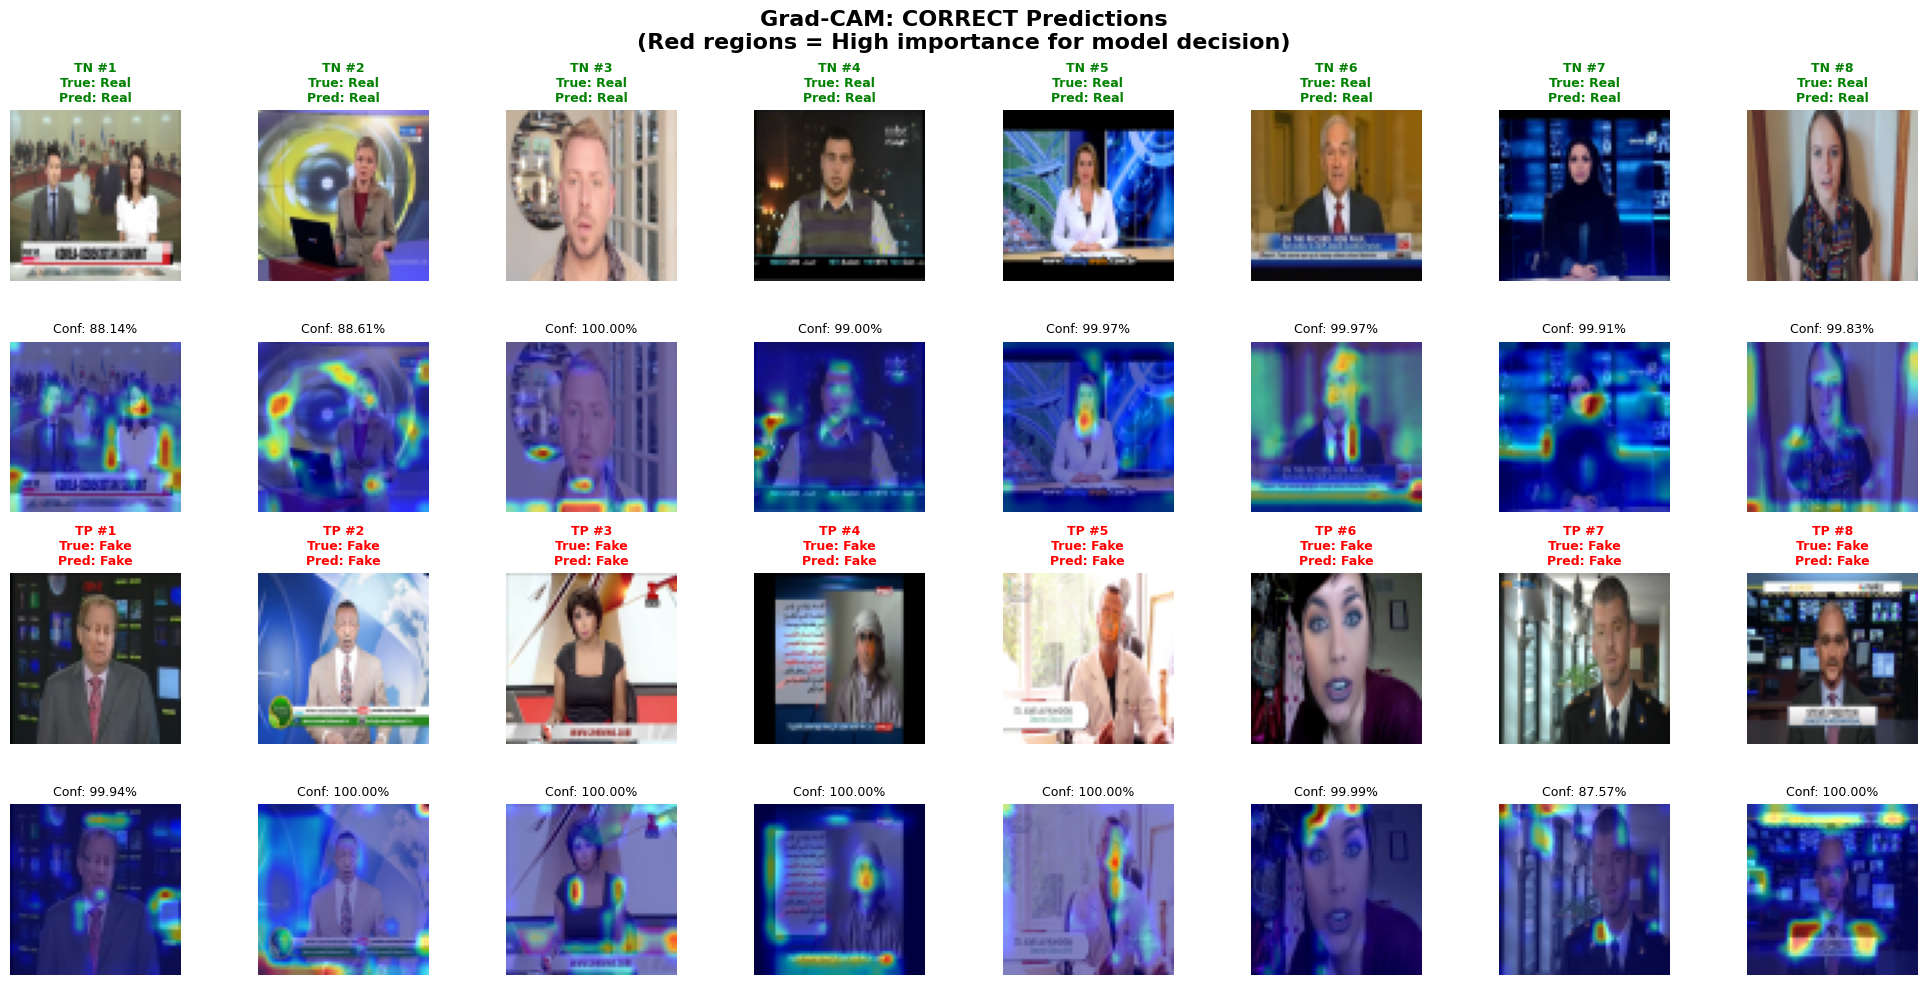

✅ Correct predictions visualized!

💡 What to look for:
   🔴 Red regions = Model focused here
   🔵 Blue regions = Model ignored these
   ✅ Good: Focus on facial features (eyes, nose, mouth)
   ❌ Bad: Focus on edges, backgrounds, or random regions


In [ ]:
print("\n📊 Visualizing Grad-CAM for CORRECT predictions...")

# Create figure for correct predictions (TN and TP)
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

# Plot TN (Correct Reals) - Top 2 rows
for i in range(min(8, len(gradcam_results['TN']['overlays']))):
    # Row 0: Original images
    axes[0, i].imshow(gradcam_results['TN']['images'][i])
    axes[0, i].set_title(f'TN #{i+1}\nTrue: Real\nPred: Real',
                         fontsize=9, color='green', fontweight='bold')
    axes[0, i].axis('off')

    # Row 1: Grad-CAM overlays
    axes[1, i].imshow(gradcam_results['TN']['overlays'][i])
    conf = gradcam_results['TN']['predictions'][i]['confidence']
    axes[1, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[1, i].axis('off')

# Plot TP (Correct Fakes) - Bottom 2 rows
for i in range(min(8, len(gradcam_results['TP']['overlays']))):
    # Row 2: Original images
    axes[2, i].imshow(gradcam_results['TP']['images'][i])
    axes[2, i].set_title(f'TP #{i+1}\nTrue: Fake\nPred: Fake',
                         fontsize=9, color='red', fontweight='bold')
    axes[2, i].axis('off')

    # Row 3: Grad-CAM overlays
    axes[3, i].imshow(gradcam_results['TP']['overlays'][i])
    conf = gradcam_results['TP']['predictions'][i]['confidence']
    axes[3, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[3, i].axis('off')

plt.suptitle('Grad-CAM: CORRECT Predictions\n(Red regions = High importance for model decision)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✅ Correct predictions visualized!")
print("\n💡 What to look for:")
print("   🔴 Red regions = Model focused here")
print("   🔵 Blue regions = Model ignored these")
print("   ✅ Good: Focus on facial features (eyes, nose, mouth)")
print("   ❌ Bad: Focus on edges, backgrounds, or random regions")

^^
Rows 0-1: True Negatives (correct reals)

Row 0: Original images
Row 1: Grad-CAM overlays (red = important)


Rows 2-3: True Positives (correct fakes)

Row 2: Original images
Row 3: Grad-CAM overlays


Shows WHERE model looks for correct predictions
Red = model focused here, Blue = ignored

## Cell 11.6: Visualize Grad-CAM Results - ERRORS



📊 Visualizing Grad-CAM for ERRORS (misclassifications)...


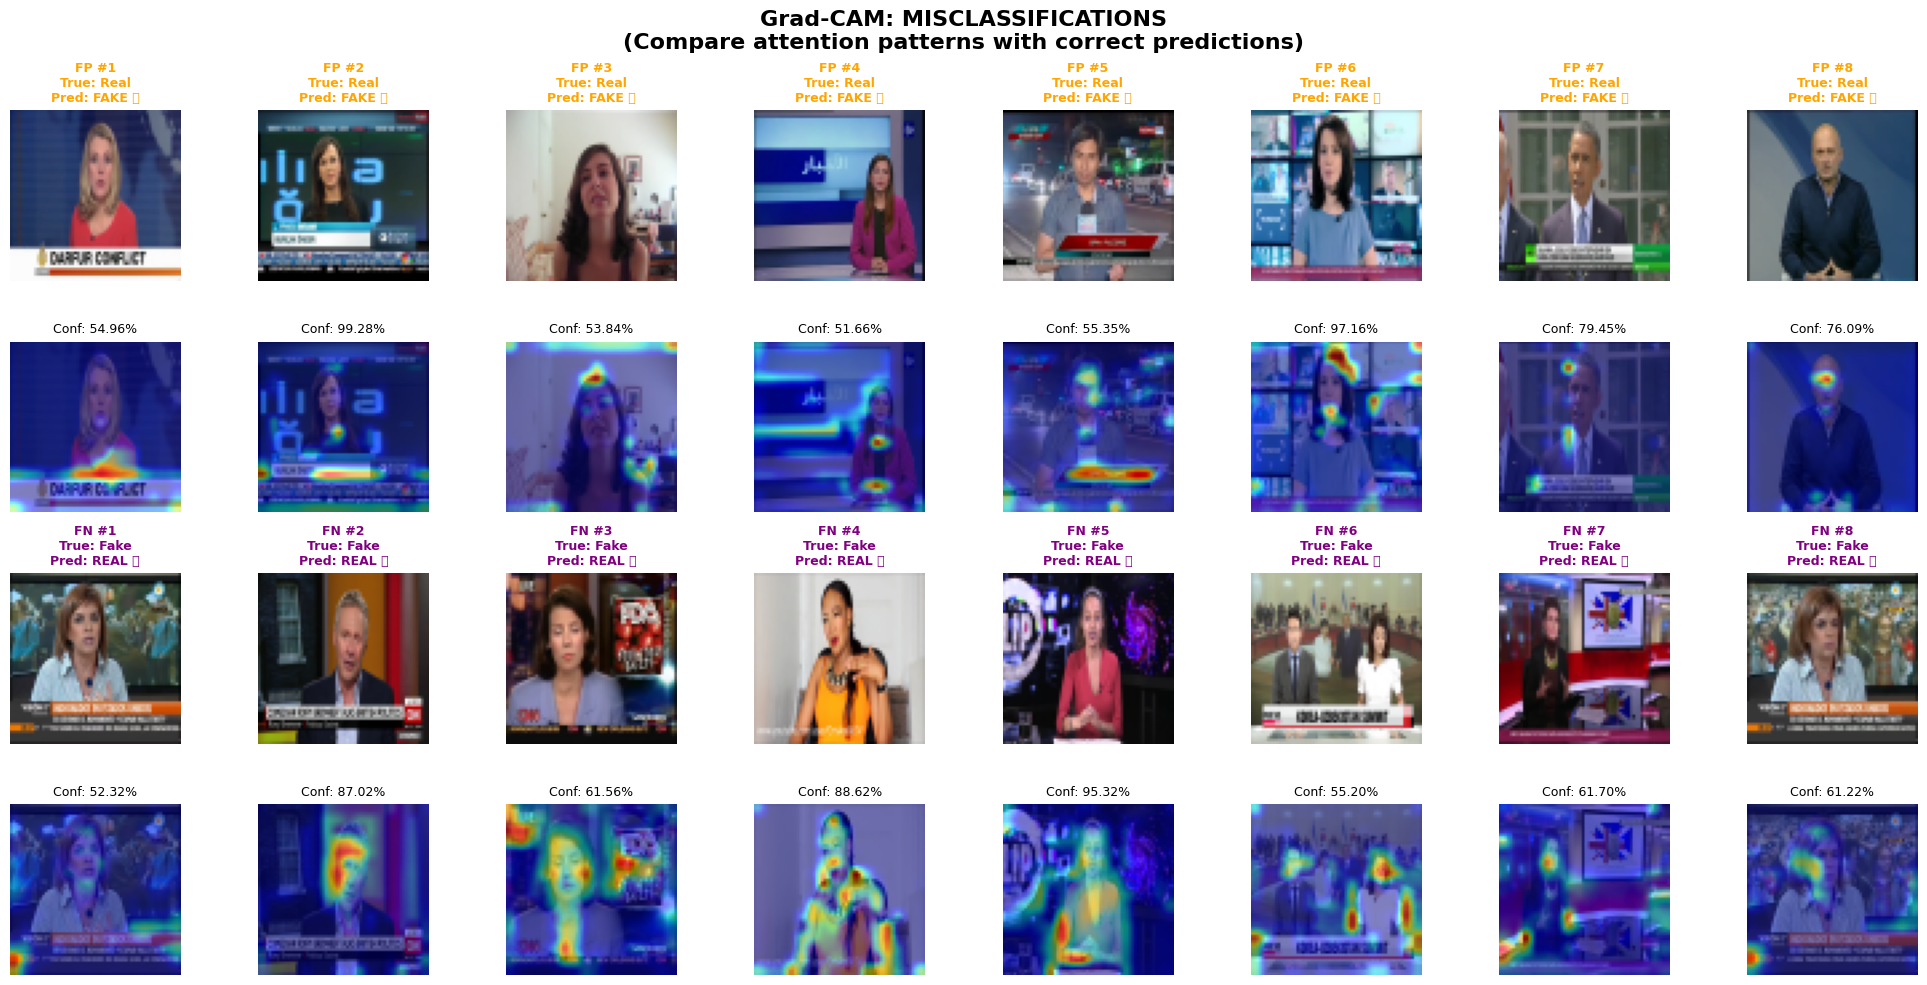

✅ Errors visualized!

💡 Analysis questions:
   1. Do FP focus on edges/artifacts instead of faces?
   2. Do FN miss obvious artifact regions?
   3. Is attention pattern different for errors vs correct?


In [ ]:
print("\n📊 Visualizing Grad-CAM for ERRORS (misclassifications)...")

# Create figure for errors (FP and FN)
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

# Plot FP (Real→Fake errors) - Top 2 rows
for i in range(min(8, len(gradcam_results['FP']['overlays']))):
    # Row 0: Original images
    axes[0, i].imshow(gradcam_results['FP']['images'][i])
    axes[0, i].set_title(f'FP #{i+1}\nTrue: Real\nPred: FAKE ❌',
                         fontsize=9, color='orange', fontweight='bold')
    axes[0, i].axis('off')

    # Row 1: Grad-CAM overlays
    axes[1, i].imshow(gradcam_results['FP']['overlays'][i])
    conf = gradcam_results['FP']['predictions'][i]['confidence']
    axes[1, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[1, i].axis('off')

# Plot FN (Fake→Real errors) - Bottom 2 rows
for i in range(min(8, len(gradcam_results['FN']['overlays']))):
    # Row 2: Original images
    axes[2, i].imshow(gradcam_results['FN']['images'][i])
    axes[2, i].set_title(f'FN #{i+1}\nTrue: Fake\nPred: REAL ❌',
                         fontsize=9, color='purple', fontweight='bold')
    axes[2, i].axis('off')

    # Row 3: Grad-CAM overlays
    axes[3, i].imshow(gradcam_results['FN']['overlays'][i])
    conf = gradcam_results['FN']['predictions'][i]['confidence']
    axes[3, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[3, i].axis('off')

plt.suptitle('Grad-CAM: MISCLASSIFICATIONS\n(Compare attention patterns with correct predictions)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✅ Errors visualized!")
print("\n💡 Analysis questions:")
print("   1. Do FP focus on edges/artifacts instead of faces?")
print("   2. Do FN miss obvious artifact regions?")
print("   3. Is attention pattern different for errors vs correct?")

^
Rows 0-1: False Positives (real wrongly called fake)

Shows what made model think these reals are fake


Rows 2-3: False Negatives (fake wrongly called real)

Shows why model missed these fakes

## Cell 11.7: Side-by-Side Comparison



📊 Creating detailed comparison for specific examples...


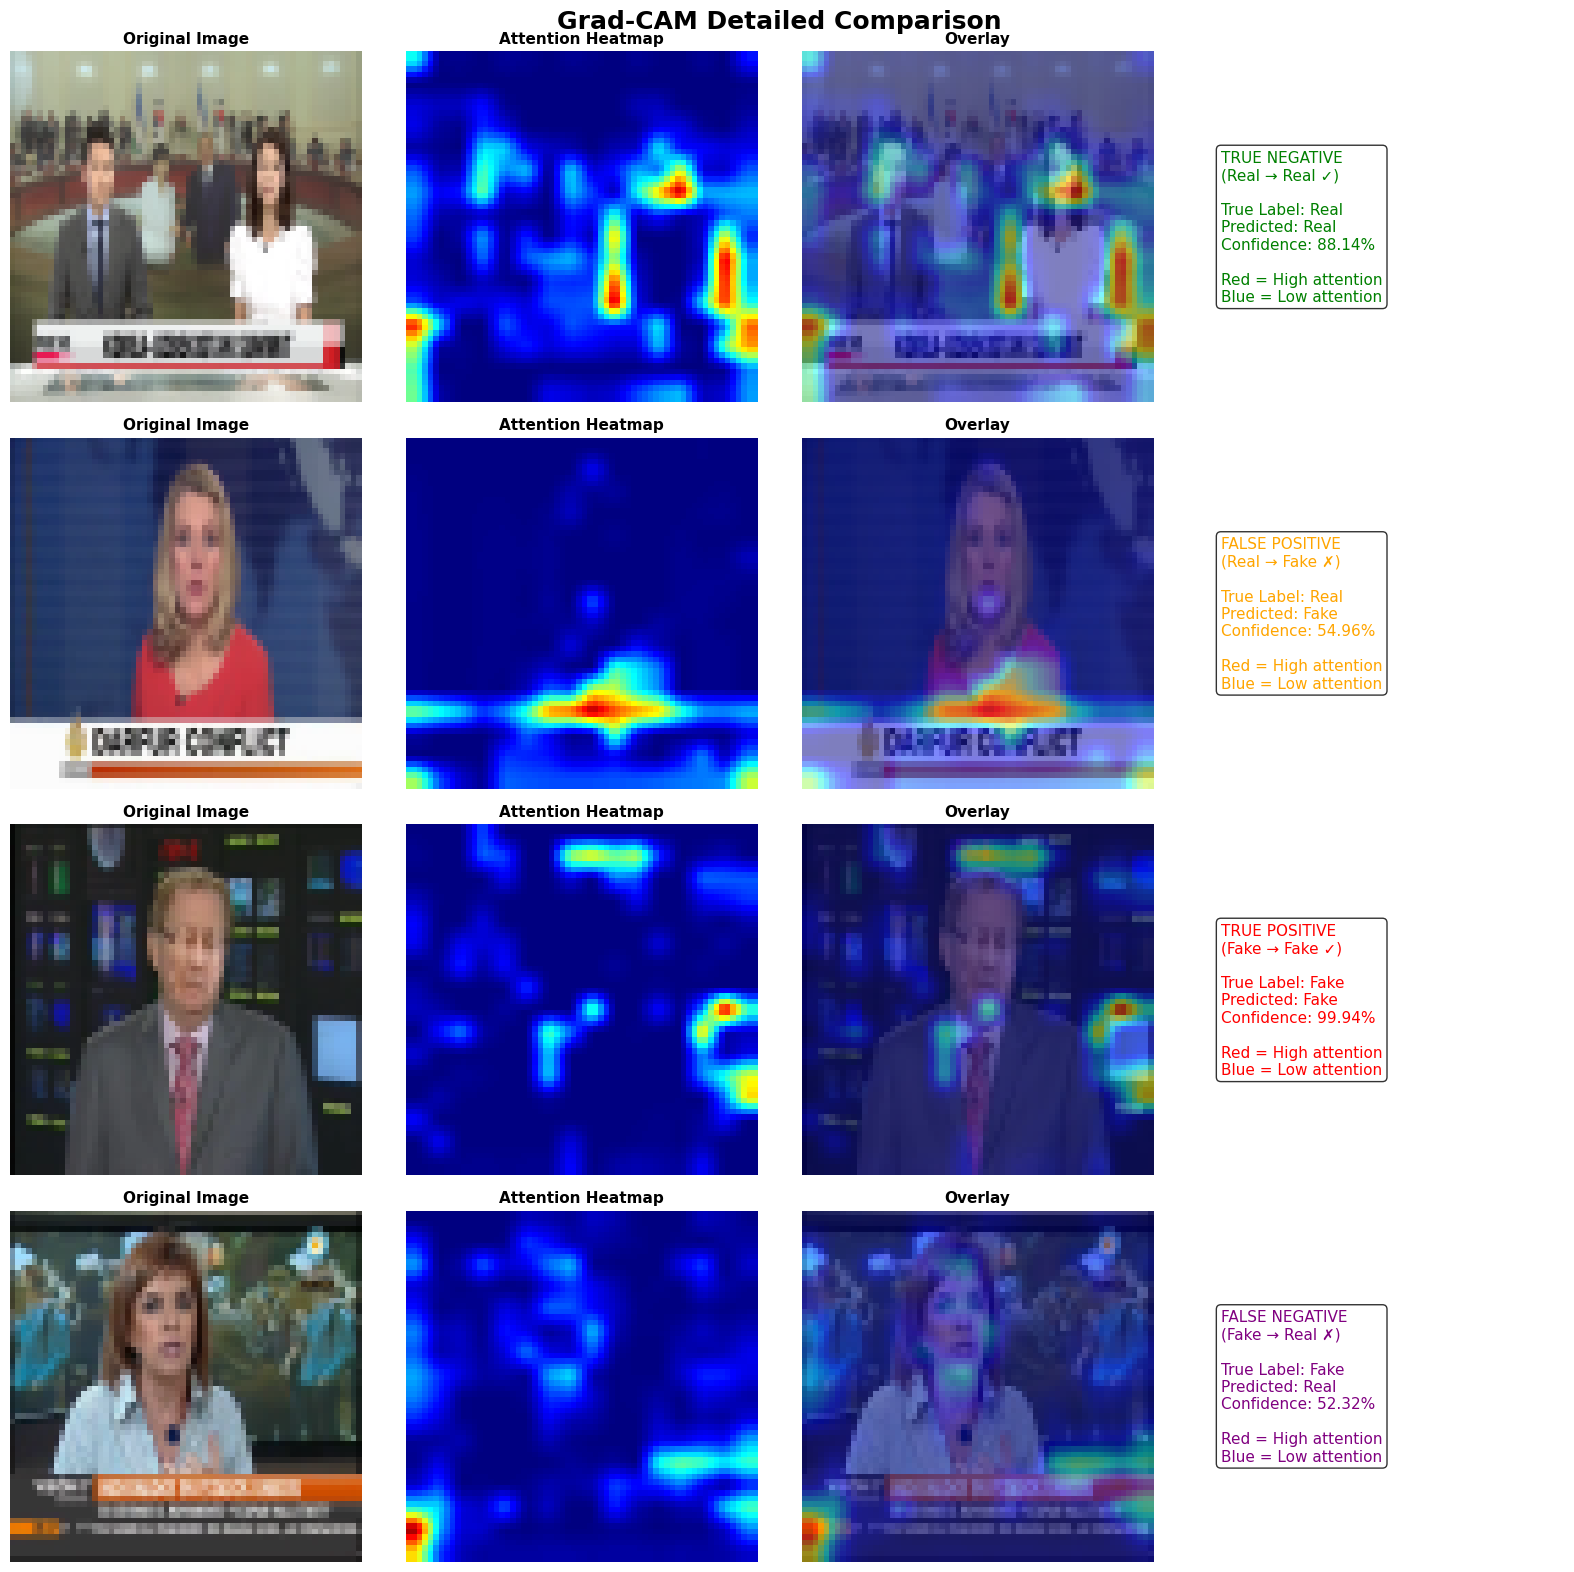

✅ Detailed comparison complete!


In [ ]:
print("\n📊 Creating detailed comparison for specific examples...")

# Pick one example from each category for detailed analysis
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

categories_to_plot = ['TN', 'FP', 'TP', 'FN']
titles = [
    'TRUE NEGATIVE\n(Real → Real ✓)',
    'FALSE POSITIVE\n(Real → Fake ✗)',
    'TRUE POSITIVE\n(Fake → Fake ✓)',
    'FALSE NEGATIVE\n(Fake → Real ✗)'
]
colors = ['green', 'orange', 'red', 'purple']

for row, (cat, title, color) in enumerate(zip(categories_to_plot, titles, colors)):
    # Use first sample from each category
    if len(gradcam_results[cat]['images']) > 0:
        img = gradcam_results[cat]['images'][0]
        overlay = gradcam_results[cat]['overlays'][0]
        heatmap = gradcam_results[cat]['heatmaps'][0]
        pred_info = gradcam_results[cat]['predictions'][0]

        # Column 0: Original image
        axes[row, 0].imshow(img)
        axes[row, 0].set_title('Original Image', fontsize=11, fontweight='bold')
        axes[row, 0].axis('off')

        # Column 1: Pure heatmap
        axes[row, 1].imshow(heatmap)
        axes[row, 1].set_title('Attention Heatmap', fontsize=11, fontweight='bold')
        axes[row, 1].axis('off')

        # Column 2: Overlay
        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title('Overlay', fontsize=11, fontweight='bold')
        axes[row, 2].axis('off')

        # Column 3: Info text
        axes[row, 3].axis('off')
        info_text = (
            f"{title}\n\n"
            f"True Label: {'Real' if pred_info['true']==0 else 'Fake'}\n"
            f"Predicted: {'Real' if pred_info['pred']==0 else 'Fake'}\n"
            f"Confidence: {pred_info['confidence']:.2%}\n\n"
            f"Red = High attention\n"
            f"Blue = Low attention"
        )
        axes[row, 3].text(0.1, 0.5, info_text, fontsize=11,
                          verticalalignment='center', color=color,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Grad-CAM Detailed Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Detailed comparison complete!")

## Cell 11.8: Quantitative Analysis of Attention Patterns


In [ ]:
print("\n" + "="*60)
print("📊 QUANTITATIVE ATTENTION ANALYSIS")
print("="*60)

# Analyze where attention is focused (center vs edges)
def analyze_attention_distribution(cam):
    """
    Analyze if attention is focused on center (face) or edges (background)

    Returns:
        center_attention: Mean attention in center 50%
        edge_attention: Mean attention in outer edges
    """
    h, w = cam.shape
    center_h_start, center_h_end = h // 4, 3 * h // 4
    center_w_start, center_w_end = w // 4, 3 * w // 4

    # Center region (middle 50%)
    center = cam[center_h_start:center_h_end, center_w_start:center_w_end]
    center_attention = center.mean()

    # Edge region (outer border)
    # Top and bottom edges
    top_edge = cam[:h//4, :]
    bottom_edge = cam[3*h//4:, :]
    # Left and right edges
    left_edge = cam[:, :w//4]
    right_edge = cam[:, 3*w//4:]

    edge_attention = np.mean([
        top_edge.mean(),
        bottom_edge.mean(),
        left_edge.mean(),
        right_edge.mean()
    ])

    return center_attention, edge_attention

# Compute statistics for each category
attention_stats = {
    'TN': {'center': [], 'edge': []},
    'TP': {'center': [], 'edge': []},
    'FP': {'center': [], 'edge': []},
    'FN': {'center': [], 'edge': []}
}

for cat in ['TN', 'TP', 'FP', 'FN']:
    for i, idx in enumerate(selected_samples[cat]):
        # Get the CAM (we need to regenerate to get raw cam values)
        img_tensor = X_test[idx].unsqueeze(0).to(device)
        pred_label = all_predictions[idx]

        # Generate CAM
        cam = grad_cam.generate_cam(img_tensor, target_class=pred_label)
        cam_resized = cv2.resize(cam, (64, 64))

        # Analyze attention distribution
        center_att, edge_att = analyze_attention_distribution(cam_resized)

        attention_stats[cat]['center'].append(center_att)
        attention_stats[cat]['edge'].append(edge_att)

# Calculate averages
print("\n📊 Average Attention Patterns:")
print(f"{'Category':<15} {'Center (Face)':<20} {'Edge (Background)':<20} {'Ratio (Center/Edge)'}")
print("="*75)

for cat in ['TN', 'TP', 'FP', 'FN']:
    center_mean = np.mean(attention_stats[cat]['center'])
    edge_mean = np.mean(attention_stats[cat]['edge'])
    ratio = center_mean / (edge_mean + 1e-10)  # Avoid division by zero

    if cat == 'TN':
        desc = "TN (Real→Real)"
    elif cat == 'TP':
        desc = "TP (Fake→Fake)"
    elif cat == 'FP':
        desc = "FP (Real→Fake)"
    else:
        desc = "FN (Fake→Real)"

    print(f"{desc:<15} {center_mean:>18.4f}   {edge_mean:>18.4f}   {ratio:>18.2f}")

print("\n💡 Interpretation:")
print("   High Ratio (>1.5): Model focuses on center (face region) ✅")
print("   Low Ratio (<1.2): Model focuses on edges (background) ❌")
print("   Compare errors (FP/FN) with correct (TN/TP)")

print("\n✅ Attention analysis complete!")


📊 QUANTITATIVE ATTENTION ANALYSIS

📊 Average Attention Patterns:
Category        Center (Face)        Edge (Background)    Ratio (Center/Edge)
TN (Real→Real)              0.1365               0.1431                 0.95
TP (Fake→Fake)              0.0752               0.1024                 0.74
FP (Real→Fake)              0.0750               0.0810                 0.93
FN (Fake→Real)              0.2155               0.1228                 1.75

💡 Interpretation:
   High Ratio (>1.5): Model focuses on center (face region) ✅
   Low Ratio (<1.2): Model focuses on edges (background) ❌
   Compare errors (FP/FN) with correct (TN/TP)

✅ Attention analysis complete!


## Cell 11.9: Summary and Interpretation Guide


In [ ]:
print("\n" + "="*60)
print("🔍 GRAD-CAM ANALYSIS SUMMARY")
print("="*60)

print("""
KEY QUESTIONS TO ANSWER FROM VISUALIZATIONS:

1. CORRECT PREDICTIONS (TN & TP):
   ✅ Does the model focus on facial features?
   ✅ Is attention concentrated in the center (face region)?
   ✅ Are eyes, nose, mouth highlighted in red?

   If YES → Model learned proper features
   If NO → Model uses shortcuts (edges, background)

2. FALSE POSITIVES (Real→Fake):
   ❌ Does model focus on compression artifacts?
   ❌ Does it highlight image edges instead of face?
   ❌ Is attention scattered/diffuse?

   These patterns explain why real images are flagged as fake
   Combined with brightness bias (from statistics), this shows
   model mistakes low-quality features for deepfake artifacts

3. FALSE NEGATIVES (Fake→Real):
   ❌ Does model miss obvious artifact regions?
   ❌ Does it focus on well-blended areas only?
   ❌ Does it ignore mouth/eye boundaries (common fake spots)?

   These high-quality fakes have smooth features that
   distract the model from subtle artifacts

4. COMPARISON - Errors vs Correct:
   🔍 Is attention pattern DIFFERENT for errors?
   🔍 Do errors have more edge/background focus?
   🔍 Do errors have lower center/edge ratios?

   Systematic differences reveal model's failure modes

WHAT TO DO BASED ON FINDINGS:

If model focuses on edges/background for errors:
   → Implement attention-guided loss
   → Force model to look at facial regions
   → Add spatial attention mechanism

If model ignores artifact regions for FN:
   → Use region-specific loss weights
   → Emphasize boundary regions (face edges, mouth, eyes)
   → Train with more challenging fakes

If no clear attention difference:
   → Errors might be truly ambiguous
   → Quality bias (from statistics) is the main issue
   → Focus on data augmentation for quality
""")

print("\n✅ Grad-CAM analysis complete!")
print("\n🎯 Next Steps:")
print("   1. Review the visualizations above")
print("   2. Compare attention patterns: errors vs correct")
print("   3. Check center/edge ratios from quantitative analysis")
print("   4. Combine with image statistics findings")
print("   5. Design custom loss based on both analyses")


🔍 GRAD-CAM ANALYSIS SUMMARY

KEY QUESTIONS TO ANSWER FROM VISUALIZATIONS:

1. CORRECT PREDICTIONS (TN & TP):
   ✅ Does the model focus on facial features?
   ✅ Is attention concentrated in the center (face region)?
   ✅ Are eyes, nose, mouth highlighted in red?
   
   If YES → Model learned proper features
   If NO → Model uses shortcuts (edges, background)

2. FALSE POSITIVES (Real→Fake):
   ❌ Does model focus on compression artifacts?
   ❌ Does it highlight image edges instead of face?
   ❌ Is attention scattered/diffuse?
   
   These patterns explain why real images are flagged as fake
   Combined with brightness bias (from statistics), this shows
   model mistakes low-quality features for deepfake artifacts

3. FALSE NEGATIVES (Fake→Real):
   ❌ Does model miss obvious artifact regions?
   ❌ Does it focus on well-blended areas only?
   ❌ Does it ignore mouth/eye boundaries (common fake spots)?
   
   These high-quality fakes have smooth features that
   distract the model from subt